In [ ]:
#!pip install ../input/monaiandeinops/einops-0.4.1-py3-none-any.whl ../input/monaiandeinops/monai-0.9.0-202206131636-py3-none-any.whl

In [ ]:
#import nibabel

In [1]:
import os, glob
import pandas as pd
import matplotlib.pyplot as plt

from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import torch
from PIL import Image
from einops import rearrange, reduce, repeat

from sklearn.model_selection import StratifiedKFold, KFold, StratifiedGroupKFold
from matplotlib.patches import Rectangle

from pathlib import Path
from IPython import display
import albumentations as trans
from einops import rearrange
from tqdm.notebook import tqdm

#DATASET_FOLDER = Path("../input/uw-madison-gi-tract-image-segmentation")
DATASET_FOLDER = Path("/media/SSD/gi-tract/uw-madison-gi-tract-image-segmentation")

TRAIN_FOLDER = DATASET_FOLDER / "train"

WORKING_FOLDER = Path("./")
#MODEL_FOLDER = WORKING_FOLDER/"models"
MODEL_FOLDER = Path('/media/SSD/gi-tract/uw-madison-gi-tract-image-segmentation/kaggle models')

os.makedirs(MODEL_FOLDER, exist_ok=True)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


## Process metadata

In [2]:
df = pd.read_csv(DATASET_FOLDER/"train.csv")
df.head()

,id,class,segmentation
0,case123_day20_slice_0001,large_bowel,NaN
1,case123_day20_slice_0001,small_bowel,NaN
2,case123_day20_slice_0001,stomach,NaN
3,case123_day20_slice_0002,large_bowel,NaN
4,case123_day20_slice_0002,small_bowel,NaN


In [3]:
pivoted = df.pivot(index="id", columns="class", values="segmentation")
#Use the pivoted data going forward
df = pivoted
df['id'] = df.index

### Parse out metadata

In [4]:
#Get Case-ID as columns (str and int)
df["case_id_str"] = df["id"].apply(lambda x: x.split("_", 2)[0])
df["case_id"] = df["case_id_str"].apply(lambda x: int(x[4::]))

#Get Day as columns (str and int)
df["day_num_str"] = df["id"].apply(lambda x: x.split("_", 2)[1])
df["day_num"] = df["day_num_str"].apply(lambda x: int(x[3::]))

#Get Slice Identifier as columns (str and int)
df["slice_id"] = df["id"].apply(lambda x: x.split("_", 2)[2])
df["slice_num"] = df["slice_id"].apply(lambda x: int(x[6::]))

# Create the path to get to the file
df['match'] = df.case_id_str + '/' + df.case_id_str + '_' + df.day_num_str + '/scans/' + df.slice_id
df.head()

class,large_bowel,small_bowel,stomach,id,case_id_str,case_id,day_num_str,day_num,slice_id,slice_num,match
id,,,,,,,,,,,
case101_day20_slice_0001,NaN,NaN,NaN,case101_day20_slice_0001,case101,101,day20,20,slice_0001,1,case101/case101_day20/scans/slice_0001
case101_day20_slice_0002,NaN,NaN,NaN,case101_day20_slice_0002,case101,101,day20,20,slice_0002,2,case101/case101_day20/scans/slice_0002
case101_day20_slice_0003,NaN,NaN,NaN,case101_day20_slice_0003,case101,101,day20,20,slice_0003,3,case101/case101_day20/scans/slice_0003
case101_day20_slice_0004,NaN,NaN,NaN,case101_day20_slice_0004,case101,101,day20,20,slice_0004,4,case101/case101_day20/scans/slice_0004
case101_day20_slice_0005,NaN,NaN,NaN,case101_day20_slice_0005,case101,101,day20,20,slice_0005,5,case101/case101_day20/scans/slice_0005


### Get paths

In [5]:
all_imgs = glob.glob(os.path.join(str(DATASET_FOLDER), "train", "case*", "case*_day*", "scans", "*.png"))
all_imgs = [p.replace(str(DATASET_FOLDER)+'/train/', "") for p in all_imgs]

#check that they match in count
print(f"images: {len(all_imgs)}")
print(f"metadata: {len(df['id'].unique())}")
file_df = pd.DataFrame(all_imgs)
file_df.columns = ["subpath"]
file_df.head()

images: 38496
metadata: 38496


,subpath
0,case24/case24_day25/scans/slice_0046_266_266_1...
1,case24/case24_day25/scans/slice_0099_266_266_1...
2,case24/case24_day25/scans/slice_0013_266_266_1...
3,case24/case24_day25/scans/slice_0064_266_266_1...
4,case24/case24_day25/scans/slice_0090_266_266_1...


### Get image metadata from file name

In [6]:
def trunc_at(s, n=3):
    "Returns s truncated at the n'th (3rd by default) occurrence of the delimiter, d."
    return '_'.join(s.split('_', n)[:n])
file_df['filename'] = file_df["subpath"].apply(lambda x: x.split("/")[-1])
file_df["match"] = file_df["subpath"].apply(trunc_at)
#Get image slice height in pixels
file_df["im_height"] = file_df["filename"].apply(lambda x: int(x.split("_", 5)[2]))

#Get image slice width in pixels
file_df["im_width"] = file_df["filename"].apply(lambda x: int(x.split("_", 5)[3]))

#Get image pixel height in mm
file_df["im_pixel_height"] = file_df["filename"].apply(lambda x: float(x.split("_", 5)[4]))

#Get image pixel width in mm
file_df["im_pixel_width"] = file_df["filename"].apply(lambda x: float(x.split("_", 5)[5].split(".png",1)[0]))

#Define physical slice thickness in mm (3.0 mm for all files)
file_df["slice_thickness"] = 3.0
file_df.head()

,subpath,filename,match,im_height,im_width,im_pixel_height,im_pixel_width,slice_thickness
0,case24/case24_day25/scans/slice_0046_266_266_1...,slice_0046_266_266_1.50_1.50.png,case24/case24_day25/scans/slice_0046,266,266,1.5,1.5,3.0
1,case24/case24_day25/scans/slice_0099_266_266_1...,slice_0099_266_266_1.50_1.50.png,case24/case24_day25/scans/slice_0099,266,266,1.5,1.5,3.0
2,case24/case24_day25/scans/slice_0013_266_266_1...,slice_0013_266_266_1.50_1.50.png,case24/case24_day25/scans/slice_0013,266,266,1.5,1.5,3.0
3,case24/case24_day25/scans/slice_0064_266_266_1...,slice_0064_266_266_1.50_1.50.png,case24/case24_day25/scans/slice_0064,266,266,1.5,1.5,3.0
4,case24/case24_day25/scans/slice_0090_266_266_1...,slice_0090_266_266_1.50_1.50.png,case24/case24_day25/scans/slice_0090,266,266,1.5,1.5,3.0


### Merge dfs

In [7]:
#create our final dataframe by joining the two dataframes
df2d = pd.merge(df, file_df, on = "match", how = "inner")
df.head()

class,large_bowel,small_bowel,stomach,id,case_id_str,case_id,day_num_str,day_num,slice_id,slice_num,match
id,,,,,,,,,,,
case101_day20_slice_0001,NaN,NaN,NaN,case101_day20_slice_0001,case101,101,day20,20,slice_0001,1,case101/case101_day20/scans/slice_0001
case101_day20_slice_0002,NaN,NaN,NaN,case101_day20_slice_0002,case101,101,day20,20,slice_0002,2,case101/case101_day20/scans/slice_0002
case101_day20_slice_0003,NaN,NaN,NaN,case101_day20_slice_0003,case101,101,day20,20,slice_0003,3,case101/case101_day20/scans/slice_0003
case101_day20_slice_0004,NaN,NaN,NaN,case101_day20_slice_0004,case101,101,day20,20,slice_0004,4,case101/case101_day20/scans/slice_0004
case101_day20_slice_0005,NaN,NaN,NaN,case101_day20_slice_0005,case101,101,day20,20,slice_0005,5,case101/case101_day20/scans/slice_0005


### Add extra columns

In [8]:
# Identify images without segmentation
#For each row find segmentations for each organ
sel1 = ~df2d.large_bowel.isnull()
sel2 = ~df2d.small_bowel.isnull()
sel3 = ~df2d.stomach.isnull()

# select rows with segments
sel_segments = sel1 | sel2 | sel3

#create a new column reflecting whether segmentations exist
df2d['segmentations'] = sel_segments
df2d['group'] = df2d.groupby(['case_id', 'day_num']).ngroup()
df2d.head()

,large_bowel,small_bowel,stomach,id,case_id_str,case_id,day_num_str,day_num,slice_id,slice_num,match,subpath,filename,im_height,im_width,im_pixel_height,im_pixel_width,slice_thickness,segmentations,group
0,NaN,NaN,NaN,case101_day20_slice_0001,case101,101,day20,20,slice_0001,1,case101/case101_day20/scans/slice_0001,case101/case101_day20/scans/slice_0001_266_266...,slice_0001_266_266_1.50_1.50.png,266,266,1.5,1.5,3.0,False,150
1,NaN,NaN,NaN,case101_day20_slice_0002,case101,101,day20,20,slice_0002,2,case101/case101_day20/scans/slice_0002,case101/case101_day20/scans/slice_0002_266_266...,slice_0002_266_266_1.50_1.50.png,266,266,1.5,1.5,3.0,False,150
2,NaN,NaN,NaN,case101_day20_slice_0003,case101,101,day20,20,slice_0003,3,case101/case101_day20/scans/slice_0003,case101/case101_day20/scans/slice_0003_266_266...,slice_0003_266_266_1.50_1.50.png,266,266,1.5,1.5,3.0,False,150
3,NaN,NaN,NaN,case101_day20_slice_0004,case101,101,day20,20,slice_0004,4,case101/case101_day20/scans/slice_0004,case101/case101_day20/scans/slice_0004_266_266...,slice_0004_266_266_1.50_1.50.png,266,266,1.5,1.5,3.0,False,150
4,NaN,NaN,NaN,case101_day20_slice_0005,case101,101,day20,20,slice_0005,5,case101/case101_day20/scans/slice_0005,case101/case101_day20/scans/slice_0005_266_266...,slice_0005_266_266_1.50_1.50.png,266,266,1.5,1.5,3.0,False,150


## Train and Validation split

In [9]:
n_folds = 5
seed = 42

In [10]:
#We will use n fold cross validation, which will create 5 training sets of 80% of the data
# and 5 validation sets of 20% of the data.
# We use the group ID to stratify the folds so that cases are not split between training and val sets

skf = StratifiedGroupKFold(n_splits=n_folds, shuffle=True, random_state=seed)
for fold, (train_idx, val_idx) in enumerate(skf.split(df2d, df2d['segmentations'], groups = df2d["group"])):
    df2d.loc[val_idx, 'fold'] = fold


In [11]:
np.unique(df2d['fold'])

array([0., 1., 2., 3., 4.])

## Utils

In [12]:
# ref: https://www.kaggle.com/paulorzp/run-length-encode-and-decode
def rle_decode(mask_rle, shape, color_val=1):
    '''
    mask_rle: run-length as string formated (start length)
    shape: (height,width) of array to return 
    Returns numpy array, color_val - mask, 0 - background

    '''
    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros((shape[0] * shape[1], shape[2]), dtype=np.float32)

    img = torch.zeros(shape[1]*shape[2])
    for lo, hi in zip(starts, ends):
        img[lo : hi] = color_val
    return img.reshape(shape)    


# ref.: https://www.kaggle.com/stainsby/fast-tested-rle
def rle_encode(img):
    '''
    img: numpy array, 1 - mask, 0 - background
    Returns run length as string formated
    '''
    pixels = img.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)

## Generate 3d images

In [13]:
from monai.transforms import LoadImage
from monai.data import NibabelWriter

def make_mask(shape, lb, sb, st):
    mask = np.zeros((4, shape[0], shape[1]))
    if isinstance(lb, str):
        mask[1,:,:] = rle_decode(lb, [1, shape[0], shape[1]] ,color_val=1)

    if isinstance(sb, str):
        mask[2,:,:] = rle_decode(sb, [1, shape[0], shape[1]] ,color_val=1)

    if isinstance(st, str):
        mask[3,:,:] = rle_decode(st, [1, shape[0], shape[1]] ,color_val=1)
    # Add background channel
    mask[0,:,:] = 1.0*((mask[1,:,:] + mask[2,:,:] + mask[3,:,:]) == 0)
    return mask

def create_image(df, src, dest, idx, writer, loader):
    img_dest = Path(f"{dest}/img_{idx}.nii.gz")
    mask_dest = Path(f"{dest}/mask_{idx}.nii.gz")
    if img_dest.exists() and mask_dest.exists():
        # Cache images already present
        return 
    slices = df.reset_index()
    row = slices.iloc[0]
    img = rearrange(loader(src / row['subpath']), 'w h -> h w')
    im_spacing = row["im_pixel_height"]
    im_affine = np.eye(4)*im_spacing
    im_affine[2,2] = 3 # All slice thicknesses are 3
    im_affine[3,3] = 1
    mask = np.zeros((slices.shape[0], 4, img.shape[0], img.shape[1]))
    for j in range(1, slices.shape[0]):
        row = slices.iloc[j]
        slice_ = rearrange(loader(src / row['subpath']), 'w h -> h w')
        img = np.dstack((img, slice_))
        mask[j,:,:,:] = make_mask(img.shape, row.large_bowel, row.small_bowel, row.stomach)
    
    # Write image
    writer.set_data_array(img, channel_dim=None)
    writer.set_metadata({
        "affine": im_affine,
        "original_affine": im_affine,
        "dtype": np.int16
    })
    writer.write(
        str(img_dest),
        verbose=False
    )
    # Write mask
    # Move channel to last dimension
    mask = rearrange(mask, 'd c h w -> h w d c')

    writer.set_data_array(mask, channel_dim=-1)
    writer.set_metadata({
        "affine": im_affine,
        "original_affine": im_affine,
        "dtype": np.int16
    })
    writer.write(
        str(mask_dest),
        verbose=False
    )

In [14]:
import multiprocessing
from concurrent.futures import ProcessPoolExecutor, as_completed
print(multiprocessing.cpu_count())
def create_images(df, src, dest):
    writer = NibabelWriter()
    loader = LoadImage(image_only=True)
    futures = []
    with ProcessPoolExecutor(max_workers=multiprocessing.cpu_count()) as pool:
        for name, group in df.groupby(['group']):
            group = group.sort_values('slice_num', ascending=True)
            case  = np.unique(group['case_id'])[0]
            day  = np.unique(group['day_num'])[0]
            fold = np.unique(group['fold'])[0]
            n_slice = group.shape[0]
            dest_folder = dest / f"{int(fold)}/case-{case}_day-{day}"
            dest_folder.mkdir(parents=True, exist_ok=True)
            futures.append(
                pool.submit(
                    create_image, group, src, dest_folder, 0, writer, loader
            )
        )
        pbar = tqdm(total=len(futures))
        for _ in as_completed(futures):
            pbar.update(1)
        pbar.close()


12


In [15]:
DEST = Path('/media/SSD/gi-tract/uw-madison-gi-tract-image-segmentation/images')
DEST.mkdir(exist_ok=True)
#df2d[df2d['case_id'] == 29][df2d['day_num'] == 13]

In [16]:
#create_images(df2d, TRAIN_FOLDER, DEST)

## Monai imports

In [17]:
from monai.transforms import (
    Activations,
    AsDiscrete,
    EnsureChannelFirstd,
    Compose,
    Resized,
    LoadImaged,
    RandCropByPosNegLabeld,
    ScaleIntensityd,
    EnsureTyped,
    EnsureType,
    ToTensord,
    SpatialPadd,
    Lambdad,
    CastToTyped,
    RandAffined,
    RandScaleIntensityd,
    RandRotated,
    RandZoomd,
    RandGridDistortiond,
    Rand3DElasticd,
    RandCoarseDropoutd,
    Pad,
    MapTransform,
    InvertibleTransform,
    Randomizable,
    ToDeviced,
    EnsureTyped,
    RandCoarseShuffled,
    RandSpatialCropd,
)

#from monai.transforms import Padd

from monai.networks.nets import UNet, AttentionUnet
from monai.networks.layers import Norm
from monai.metrics import DiceMetric
from monai.losses import DiceLoss, DiceCELoss
from monai.inferers import sliding_window_inference
from monai.data import DataLoader, Dataset, decollate_batch, list_data_collate, CacheDataset, PersistentDataset

## Transforms for train and validation

In [18]:
from typing import Any, Callable, List, Optional, Sequence, Tuple, Union
from typing import Any, Callable, Dict, Hashable, List, Mapping, Optional, Sequence, Union
from monai.config import IndexSelection, KeysCollection
from monai.data.meta_tensor import MetaTensor
from monai.utils import (
    PytorchPadMode,
    ensure_tuple_rep

)






class SquarePad(Pad):
    """
    Performs padding to the data, making WxH square using max(W,H).

    Args:
        dim1: The first dimension to pad to a square.
        dim2: The second dimension to pad to a square.
        mode: available modes for numpy array:{``"constant"``, ``"edge"``, ``"linear_ramp"``, ``"maximum"``,
            ``"mean"``, ``"median"``, ``"minimum"``, ``"reflect"``, ``"symmetric"``, ``"wrap"``, ``"empty"``}
            available modes for PyTorch Tensor: {``"constant"``, ``"reflect"``, ``"replicate"``, ``"circular"``}.
            One of the listed string values or a user supplied function. Defaults to ``"constant"``.
            See also: https://numpy.org/doc/1.18/reference/generated/numpy.pad.html
            https://pytorch.org/docs/stable/generated/torch.nn.functional.pad.html
        kwargs: other arguments for the `np.pad` or `torch.pad` function.
            note that `np.pad` treats channel dimension as the first dimension.

    """

    def __init__(
        self,
        #spatial_size: Union[Sequence[int], int],
        dim1: int,
        dim2: int,
        mode: str = PytorchPadMode.CONSTANT,
        **kwargs,
    ) -> None:
        #self.spatial_size = spatial_size
        self.dim1 = dim1
        self.dim2 = dim2
        super().__init__(to_pad=None,mode=mode, **kwargs)


    def compute_pad_width(self, spatial_shape: Sequence[int]) -> List[Tuple[int, int]]:
        """
        Square the rectange of dim1 and dim2.

        Args:
            dim1: first dimension of the square.
            dim2: second dimension fo the square.

        """
        
            
        square_width = max(spatial_shape[self.dim1],spatial_shape[self.dim2])

        pad_width = [0]*len(spatial_shape)

        p1 = max(0,square_width - spatial_shape[self.dim1])
        p2 = max(0,square_width - spatial_shape[self.dim2])

        pad_width[self.dim1] = (p1 // 2, p1 - (p1 // 2))
        pad_width[self.dim2] = (p2 // 2, p2 - (p2 // 2))

        pad_width = []
        for i, sp_i in enumerate(spatial_size):
            width = max(sp_i - spatial_shape[i], 0)
            pad_width.append((width // 2, width - (width // 2)))
        
        return [(0, 0)] + pad_width

In [19]:
class Padd(MapTransform, InvertibleTransform):
    """
    Dictionary-based wrapper of :py:class:`monai.transforms.Pad`.

    """

    backend = Pad.backend


    def __init__(
        self,
        keys: KeysCollection,
        padder: Pad,
        mode = PytorchPadMode.CONSTANT,
        allow_missing_keys: bool = False,
    ) -> None:
        """
        Args:
            keys: keys of the corresponding items to be transformed.
                See also: :py:class:`monai.transforms.compose.MapTransform`
            padder: pad transform for the input image.
            mode: available modes for numpy array:{``"constant"``, ``"edge"``, ``"linear_ramp"``, ``"maximum"``,
                ``"mean"``, ``"median"``, ``"minimum"``, ``"reflect"``, ``"symmetric"``, ``"wrap"``, ``"empty"``}
                available modes for PyTorch Tensor: {``"constant"``, ``"reflect"``, ``"replicate"``, ``"circular"``}.
                One of the listed string values or a user supplied function. Defaults to ``"constant"``.
                See also: https://numpy.org/doc/1.18/reference/generated/numpy.pad.html
                https://pytorch.org/docs/stable/generated/torch.nn.functional.pad.html
                It also can be a sequence of string, each element corresponds to a key in ``keys``.
            allow_missing_keys: don't raise exception if key is missing.

        """
        super().__init__(keys, allow_missing_keys)
        self.padder = padder
        self.mode = ensure_tuple_rep(mode, len(self.keys))



    def __call__(self, data: Mapping[Hashable, torch.Tensor]) -> Dict[Hashable, torch.Tensor]:
        d = dict(data)
        for key, m in self.key_iterator(d, self.mode):
            d[key] = self.padder(d[key], mode=m)
        return d



    def inverse(self, data: Mapping[Hashable, MetaTensor]) -> Dict[Hashable, MetaTensor]:
        d = dict(data)
        for key in self.key_iterator(d):
            d[key] = self.padder.inverse(d[key])
        return d

In [20]:
class SquarePadd(Padd):
    """
    Dictionary-based wrapper of :py:class:`monai.transforms.SpatialPad`.
    Performs padding to the data, symmetric for all sides or all on one side for each dimension.

    """


    def __init__(
        self,
        keys: KeysCollection,
        dim1: int,
        dim2: int,
        mode = PytorchPadMode.CONSTANT,
        allow_missing_keys: bool = False,
        **kwargs,
    ) -> None:
        """
        Args:
            keys: keys of the corresponding items to be transformed.
                See also: :py:class:`monai.transforms.compose.MapTransform`
            
            
            
            mode: available modes for numpy array:{``"constant"``, ``"edge"``, ``"linear_ramp"``, ``"maximum"``,
                ``"mean"``, ``"median"``, ``"minimum"``, ``"reflect"``, ``"symmetric"``, ``"wrap"``, ``"empty"``}
                available modes for PyTorch Tensor: {``"constant"``, ``"reflect"``, ``"replicate"``, ``"circular"``}.
                One of the listed string values or a user supplied function. Defaults to ``"constant"``.
                See also: https://numpy.org/doc/1.18/reference/generated/numpy.pad.html
                https://pytorch.org/docs/stable/generated/torch.nn.functional.pad.html
                It also can be a sequence of string, each element corresponds to a key in ``keys``.
            allow_missing_keys: don't raise exception if key is missing.
            kwargs: other arguments for the `np.pad` or `torch.pad` function.
                note that `np.pad` treats channel dimension as the first dimension.

        """
        padder = SquarePad(dim1,dim2, **kwargs)
        super().__init__(keys, padder=padder, mode=mode, allow_missing_keys=allow_missing_keys)

In [21]:
#from monai.data.utils import get_random_patch, get_valid_patch_size

from monai.transforms.croppad.array import CenterSpatialCrop
from monai.config.type_definitions import NdarrayOrTensor

from monai.utils import fall_back_tuple

from monai.data.utils import get_random_patch, get_valid_patch_size

#from monai.config import KeysCollection

class RandZCropd(Randomizable, MapTransform, InvertibleTransform):
    """
    Random crops in Z direction only

    Args:
        keys: keys of the corresponding items to be transformed.
            See also: monai.transforms.MapTransform
        roi_size: if `random_size` is True, it specifies the minimum crop region.
            if `random_size` is False, it specifies the expected ROI size to crop. e.g. [224, 224, 128]
            if a dimension of ROI size is bigger than image size, will not crop that dimension of the image.
            If its components have non-positive values, the corresponding size of input image will be used.
            for example: if the spatial size of input data is [40, 40, 40] and `roi_size=[32, 64, -1]`,
            the spatial size of output data will be [32, 40, 40].
        max_roi_size: if `random_size` is True and `roi_size` specifies the min crop region size, `max_roi_size`
            can specify the max crop region size. if None, defaults to the input image size.
            if its components have non-positive values, the corresponding size of input image will be used.
        random_center: crop at random position as center or the image center.
        random_size: crop with random size or specific size ROI.
            if True, the actual size is sampled from:
            `randint(roi_scale * image spatial size, max_roi_scale * image spatial size + 1)`.
        allow_missing_keys: don't raise exception if key is missing.
    """

    backend = CenterSpatialCrop.backend

    def __init__(
        self,
        keys: KeysCollection,
        roi_size: Union[Sequence[int], int],
        max_roi_size: Optional[Union[Sequence[int], int]] = None,
        random_center: bool = True,
        random_size: bool = True,
        allow_missing_keys: bool = False,
    ) -> None:
        MapTransform.__init__(self, keys, allow_missing_keys)
        self.roi_size = roi_size
        self.max_roi_size = max_roi_size
        self.random_center = random_center
        self.random_size = random_size
        self._slices: Optional[Tuple[slice, ...]] = None
        self._size: Optional[Sequence[int]] = None


    def randomize(self, img_size: Sequence[int]) -> None:
        self._size = fall_back_tuple(self.roi_size, img_size)
        if self.random_size:
            max_size = img_size if self.max_roi_size is None else fall_back_tuple(self.max_roi_size, img_size)
            if any(i > j for i, j in zip(self._size, max_size)):
                raise ValueError(f"min ROI size: {self._size} is bigger than max ROI size: {max_size}.")
            self._size = [self.R.randint(low=self._size[i], high=max_size[i] + 1) for i in range(len(img_size))]
        if self.random_center:
            valid_size = get_valid_patch_size(img_size, self._size)
            p = get_random_patch(img_size, valid_size, self.R)
            #print(p)
            self._slices = (slice(None),) + p



    def __call__(self, data: Mapping[Hashable, NdarrayOrTensor]) -> Dict[Hashable, NdarrayOrTensor]:
        d = dict(data)
        first_key: Union[Hashable, List] = self.first_key(d)
        if first_key == []:
            return d

        self.randomize(d[first_key].shape[1:])  # type: ignore
        if self._size is None:
            raise RuntimeError("self._size not specified.")
        for key in self.key_iterator(d):
            if self.random_center:
                self.push_transform(d, key, {"slices": [(i.start, i.stop) for i in self._slices[1:]]})  # type: ignore
                d[key] = d[key][self._slices]
            else:
                self.push_transform(d, key)
                cropper = CenterSpatialCrop(self._size)
                d[key] = cropper(d[key])
        return d



    def inverse(self, data: Mapping[Hashable, NdarrayOrTensor]) -> Dict[Hashable, NdarrayOrTensor]:
        d = deepcopy(dict(data))

        for key in self.key_iterator(d):
            transform = self.get_most_recent_transform(d, key)
            # Create inverse transform
            orig_size = transform[TraceKeys.ORIG_SIZE]
            random_center = self.random_center
            pad_to_start = np.empty((len(orig_size)), dtype=np.int32)
            pad_to_end = np.empty((len(orig_size)), dtype=np.int32)
            if random_center:
                for i, _slice in enumerate(transform[TraceKeys.EXTRA_INFO]["slices"]):
                    pad_to_start[i] = _slice[0]
                    pad_to_end[i] = orig_size[i] - _slice[1]
            else:
                current_size = d[key].shape[1:]
                for i, (o_s, c_s) in enumerate(zip(orig_size, current_size)):
                    pad_to_start[i] = pad_to_end[i] = (o_s - c_s) / 2
                    if o_s % 2 == 0 and c_s % 2 == 1:
                        pad_to_start[i] += 1
                    elif o_s % 2 == 1 and c_s % 2 == 0:
                        pad_to_end[i] += 1
            # interleave mins and maxes
            pad = list(chain(*zip(pad_to_start.tolist(), pad_to_end.tolist())))
            inverse_transform = BorderPad(pad)
            # Apply inverse transform
            d[key] = inverse_transform(d[key])
            # Remove the applied transform
            self.pop_transform(d, key)

        return d

In [22]:
RAND_SAMPLES=4  ## No longer used since we are using the simpler crop

def deg_to_rad(d):
    return d*0.01745329

train_transforms=[]

t = Compose(
    [
        # Deterministic transforms
        LoadImaged(keys=["img","mask"]),
        EnsureChannelFirstd(keys=["img", "mask"]),
        EnsureTyped(keys=["img", "mask"],dtype=torch.float32),
        ToDeviced(keys=["img", "mask"], device=device),
        #Lambdad(keys=['mask'], func=lambda mask: print(mask.shape),
        ScaleIntensityd(keys=["img","mask"]),
        
        SquarePadd(keys=["img","mask"],dim1=0,dim2=1),
        #SpatialPadd(keys=["img","mask"],spatial_size=(360,360,-1)),
        Resized(keys=["img","mask"],spatial_size=(256,256,-1)),
        RandZCropd(keys=["img", "mask"], roi_size=(256,256,16), random_size=False,
                         max_roi_size=None, random_center=True),
        
        

        
        
    ]
)

train_transforms.append(t)

t = Compose(
    [
        # Deterministic transforms
        LoadImaged(keys=["img","mask"]),
        EnsureChannelFirstd(keys=["img", "mask"]),
        EnsureTyped(keys=["img", "mask"],dtype=torch.float32),
        ToDeviced(keys=["img", "mask"], device=device),
        
        #Lambdad(keys=['mask'], func=lambda mask: print(mask.shape),
        ScaleIntensityd(keys=["img","mask"]),
        SquarePadd(keys=["img","mask"],dim1=0,dim2=1),
        #SpatialPadd(keys=["img","mask"],spatial_size=(360,360,-1)),
        Resized(keys=["img","mask"],spatial_size=(256,256,-1)),
        
        RandZCropd(keys=["img", "mask"], roi_size=(256,256,16), random_size=False,
                         max_roi_size=None, random_center=True),
        RandCoarseShuffled(keys=["img", "mask"], max_holes=8, holes=2,
                           spatial_size=(256//20,256//20,1), max_spatial_size=(256//10,256//10,4),
                           prob=0.5),
        
        # Random transforms
        # Approx 10% chance of up to 10 degree random rotation
        #RandRotated(keys=['img', 'mask'],prob=1.0, range_z=deg_to_rad(15), padding_mode="zeros"),
        #RandZoomd(keys=['img', 'mask'],prob=1.0,min_zoom=(.95,.95,.95),max_zoom=(1.05,1.05,1.05)),
        Rand3DElasticd(keys=['img', 'mask'],prob=0.5, sigma_range=(10,30), magnitude_range=(50,150),
                       spatial_size=None, rotate_range=(.01,.01,.1), shear_range=None,
                       translate_range=None, scale_range=(.05,.05,.05),device=device),
        RandGridDistortiond(keys=['img', 'mask'],prob=0.5,num_cells=10, distort_limit=0.2,
                            padding_mode="zeros",device=device),
        #RandAffined(keys=['img', 'mask'],rotate_range=[-0.2, 0.2],),
        
        
        
        #SpatialPadd(keys=['img', 'mask'], spatial_size=[256,256,16]),
        #CastToTyped(keys=['img', 'mask'])
        
        
    ]
)

train_transforms.append(t)


val_transforms = Compose(
    [
        # Deterministic transforms
        LoadImaged(keys=["img","mask"]),
        EnsureChannelFirstd(keys=["img", "mask"]),
        ScaleIntensityd(keys=["img","mask"]),
        
    ]
)

val_transforms_old = Compose(
    [
        # Deterministic transforms
        LoadImaged(keys=["img","mask"]),
        EnsureChannelFirstd(keys=["img", "mask"]),
        ScaleIntensityd(keys=["img","mask"]),
        # Random transforms
        RandCropByPosNegLabeld(
            # Note x,y,z here must be divisible by 16
            keys=["img", "mask"],
            label_key="mask",
            spatial_size=[128, 128, 16],
            pos=1,
            neg=1,
            num_samples=2
        ),
        SpatialPadd(keys=['img', 'mask'], spatial_size=[128,128,16]),
        CastToTyped(keys=['img', 'mask'])
    ]
)

## Function to get dataloaders

In [23]:
import tempfile
def get_data_dict_list(df):
    data = []
    for name, group in df.groupby(['group']):
        entry = {}
        case  = np.unique(group['case_id'])[0]
        day  = np.unique(group['day_num'])[0]
        fold = np.unique(group['fold'])[0]
        n_slice = group.shape[0]
        dest_folder = DEST / f"{int(fold)}/case-{case}_day-{day}"
        img = Path(f"{dest_folder}/img_0.nii.gz")
        mask = Path(f"{dest_folder}/mask_0.nii.gz")
        if not (img.exists() and img.is_file()):
            raise RuntimeError(f'{img} doesnt exist')
        if not (mask.exists() and mask.is_file()):
            raise RuntimeError(f'{mask} doesnt exist')
        entry['img'] = img
        entry['mask'] = mask
        data.append(entry)
    return data
    
def get_data_loader(df, fold,train_trans,train_batch_size):
    train_df = df[df['fold'] != fold]
    valid_df = df[df['fold'] == fold]
    
    train = get_data_dict_list(train_df)
    valid = get_data_dict_list(valid_df)
    print("Train Length:",len(train),"Val Length:",len(valid))
    
    persistent_cache = DATASET_FOLDER/"persistent_cache"
    persistent_cache.mkdir(parents=True, exist_ok=True)
    
    #train_ds = CacheDataset(
    train_ds = Dataset(
    #train_ds = PersistentDataset(
        data=train, 
        transform=train_trans,
        #cache_rate=0.05,
        #num_workers=1,
        #copy_cache=False,
        #cache_dir=persistent_cache,
    )
    train_loader = DataLoader(
        train_ds,
        batch_size=train_batch_size,
        shuffle=True,
        num_workers=0,
        collate_fn=list_data_collate,
        pin_memory=False,
    )
    
    # Use other fold ids for validation
    # Validation set loader
    val_ds = Dataset(
    #val_ds = PersistentDataset(
        data=valid,
        transform=val_transforms,
        #cache_dir=persistent_cache,
        #cache_dir=tempfile.gettempdir()
    )
    val_loader = DataLoader(
        val_ds,
        batch_size=1,
        num_workers=0,
        collate_fn=list_data_collate
    )
    return train_loader, val_loader

### Inspect one batch

In [ ]:
from matplotlib import animation

def plot_data3d(image, mask):
    frames = 16
    interval = 200
    start_frame = 0
    img = rearrange(image, 'n c h w d -> n h w d c')
    mask = rearrange(mask, 'n c h w d -> n h w d c')
    # Plot first 4 images
    fig, ax = plt.subplots(2, 4, figsize=(15,10))
    print(image.shape, img.shape)
    ax = ax.ravel()
    ims = []
    masks = []

    # Start by adding the image to each axis
    for i in range(len(ax)):
        im_min = img[i].min()
        im_max = img[i].max()
        # Plot the i'th image at the starting frame
        im_plot = ax[i].imshow(
            img[i,:,:,start_frame,:],
            cmap='bone',
            vmin=im_min,
            vmax=im_max
        )
        print(mask.max())
        mask_plot = ax[i].imshow(mask[i,:,:,start_frame,1:4], alpha=0.3)
        ims.append(im_plot)
        masks.append(mask_plot)
    print(im_min, im_max)
        
    def animate(frame):
        for i in range(len(ax)):
            # Update the i'th image to the data from the j'th frame
            ims[i].set_array(img[i,:,:,frame])
            masks[i].set_array(mask[i,:,:,frame,1:4])
        return ims, masks
    anim = animation.FuncAnimation(fig, animate, interval=interval, frames=frames)
    video = anim.to_html5_video()
  
    # embedding for the video
    html = display.HTML(video)
  
    # draw the animation
    display.display(html)
    plt.tight_layout()
    plt.close()

In [ ]:
def plot_data3d(image, mask,b,start_frame):
    
    img = rearrange(image, 'n c h w d -> n h w d c').cpu().numpy()
    mask = rearrange(mask, 'n c h w d -> n h w d c').cpu().numpy()
    # Plot first 4 images
    fig, ax = plt.subplots(4, 4, figsize=(20,20))
    
    #print(image.shape, img.shape)
    ax = ax.ravel()
    ims = []
    masks = []

    # Start by adding the image to each axis
    for i in range(len(ax)):
        im_min = img[b].min()
        im_max = img[b].max()
        # Plot the i'th image at the starting frame
        im_plot = ax[i].imshow(
            img[b,:,:,start_frame+i,:],
            cmap='bone',
            vmin=im_min,
            vmax=im_max
        )
        #print(mask.max())
        mask_plot = ax[i].imshow(mask[b,:,:,start_frame+i,1:4], alpha=0.3)
        #ims.append(im_plot)
        #masks.append(mask_plot)
        ax[i].axis('off')
    print(im_min, im_max)
    print(img.shape)

In [ ]:
import gc
gc.collect()

In [ ]:
from monai.utils.misc import first
fold = 0
#train_ds, val_ds = get_data_loader(df2d, fold,train_transforms[1],4)

In [ ]:
#check_data = first(train_ds)

In [ ]:
#data = iter(train_ds)

In [ ]:
#check_data = next(data)

In [ ]:

#plot_data3d(check_data['img'], check_data['mask'],0,0)

## Model

In [24]:
def plot_metrics(loss, metric):
    fig, ax = plt.subplots(1,2)
    loss_line, = ax[0].plot(loss, label='loss')
    metric_line, = ax[1].plot(metric, label='metric')
    ax[0].legend(handles=[loss_line])
    ax[1].legend(handles=[metric_line])

### Need to save the fold 4 model to all the other models so that they become the initial condition

Complete
'0_dict_7.pth' to '4_dict_7.pth' copied from '4_dict7.pth' and backups in 'backup dict_7'

### Training phase 8 - use augmentation transforms

In [25]:
#Training settings


#fn="/media/SSD/gi-tract/uw-madison-gi-tract-image-segmentation/kaggle models/best_weights_fold_0.pth"
#model.load_state_dict(torch.load(fn),strict=False)

amp = True

training_phase = 8
load_weights = True

#tr_transforms = train_transforms[0]
#batch_size = 8

tr_transforms = train_transforms[1]
batch_size = 6

num_epochs = 40
num_folds = 5
start_fold = 0
val_interval = 5
roi_size = (256, 256, 80)

metric_function = DiceMetric(include_background=True, reduction="mean", get_not_nans=False)
loss_function = DiceCELoss(include_background=False, softmax=True)

LR = torch.optim.lr_scheduler.OneCycleLR
max_learning_rate = 0.001
min_learning_rate = 0.001


----------
fold 1/5
Train Length: 220 Val Length: 54
----------
epoch 1/40  LR=3.9999999999999996e-05


  0%|          | 0/37 [00:00<?, ?it/s]

epoch 1 average loss: 1.0519
----------
epoch 2/40  LR=5.6429102309004894e-05


  0%|          | 0/37 [00:00<?, ?it/s]

epoch 2 average loss: 1.0479
----------
epoch 3/40  LR=0.00010459176172485389


  0%|          | 0/37 [00:00<?, ?it/s]

epoch 3 average loss: 1.0486
----------
epoch 4/40  LR=0.00018119102300164392


  0%|          | 0/37 [00:00<?, ?it/s]

epoch 4 average loss: 1.0492
----------
epoch 5/40  LR=0.00028098331488808095


  0%|          | 0/37 [00:00<?, ?it/s]

epoch 5 average loss: 1.0522


  0%|          | 0/54 [00:00<?, ?it/s]

----------
Validation
Metric: 0.661516547203064
saved new best metric model
current epoch: 5 current mean dice: 0.6615 best mean dice: 0.6615 at epoch 5
----------
epoch 6/40  LR=0.00039713739666311337


  0%|          | 0/37 [00:00<?, ?it/s]

epoch 6 average loss: 1.0525
----------
epoch 7/40  LR=0.0005217019879388641


  0%|          | 0/37 [00:00<?, ?it/s]

epoch 7 average loss: 1.0579
----------
epoch 8/40  LR=0.0006461500703230469


  0%|          | 0/37 [00:00<?, ?it/s]

epoch 8 average loss: 1.0580
----------
epoch 9/40  LR=0.0007619626009921238


  0%|          | 0/37 [00:00<?, ?it/s]

epoch 9 average loss: 1.0657
----------
epoch 10/40  LR=0.0008612116803001482


  0%|          | 0/37 [00:00<?, ?it/s]

epoch 10 average loss: 1.0665


  0%|          | 0/54 [00:00<?, ?it/s]

----------
Validation
Metric: 0.4511643946170807
current epoch: 10 current mean dice: 0.4512 best mean dice: 0.6615 at epoch 5
----------
epoch 11/40  LR=0.0009371032529220119


  0%|          | 0/37 [00:00<?, ?it/s]

epoch 11 average loss: 1.0669
----------
epoch 12/40  LR=0.0009844421921452319


  0%|          | 0/37 [00:00<?, ?it/s]

epoch 12 average loss: 1.0636
----------
epoch 13/40  LR=0.0009999977011100945


  0%|          | 0/37 [00:00<?, ?it/s]

epoch 13 average loss: 1.0665
----------
epoch 14/40  LR=0.0009966840720691266


  0%|          | 0/37 [00:00<?, ?it/s]

epoch 14 average loss: 1.0619
----------
epoch 15/40  LR=0.0009871243777902386


  0%|          | 0/37 [00:00<?, ?it/s]

epoch 15 average loss: 1.0649


  0%|          | 0/54 [00:00<?, ?it/s]

----------
Validation
Metric: 0.3948974609375
current epoch: 15 current mean dice: 0.3949 best mean dice: 0.6615 at epoch 5
----------
epoch 16/40  LR=0.0009714388369756511


  0%|          | 0/37 [00:00<?, ?it/s]

epoch 16 average loss: 1.0581
----------
epoch 17/40  LR=0.0009498247044020708


  0%|          | 0/37 [00:00<?, ?it/s]

epoch 17 average loss: 1.0597
----------
epoch 18/40  LR=0.000922553790327422


  0%|          | 0/37 [00:00<?, ?it/s]

epoch 18 average loss: 1.0585
----------
epoch 19/40  LR=0.0008899690423191465


  0%|          | 0/37 [00:00<?, ?it/s]

epoch 19 average loss: 1.0575
----------
epoch 20/40  LR=0.0008524802324895594


  0%|          | 0/37 [00:00<?, ?it/s]

epoch 20 average loss: 1.0599


  0%|          | 0/54 [00:00<?, ?it/s]

----------
Validation
Metric: 0.29966679215431213
current epoch: 20 current mean dice: 0.2997 best mean dice: 0.6615 at epoch 5
----------
epoch 21/40  LR=0.000810558804373782


  0%|          | 0/37 [00:00<?, ?it/s]

epoch 21 average loss: 1.0648
----------
epoch 22/40  LR=0.0007647319442537491


  0%|          | 0/37 [00:00<?, ?it/s]

epoch 22 average loss: 1.0598
----------
epoch 23/40  LR=0.0007155759514848339


  0%|          | 0/37 [00:00<?, ?it/s]

epoch 23 average loss: 1.0595
----------
epoch 24/40  LR=0.000663708991197077


  0%|          | 0/37 [00:00<?, ?it/s]

epoch 24 average loss: 1.0622
----------
epoch 25/40  LR=0.0006097833205100079


  0%|          | 0/37 [00:00<?, ?it/s]

epoch 25 average loss: 1.0579


  0%|          | 0/54 [00:00<?, ?it/s]

----------
Validation
Metric: 0.5408623814582825
current epoch: 25 current mean dice: 0.5409 best mean dice: 0.6615 at epoch 5
----------
epoch 26/40  LR=0.0005544770860209196


  0%|          | 0/37 [00:00<?, ?it/s]

epoch 26 average loss: 1.0607
----------
epoch 27/40  LR=0.0004984857957179372


  0%|          | 0/37 [00:00<?, ?it/s]

epoch 27 average loss: 1.0559
----------
epoch 28/40  LR=0.000442513572563524


  0%|          | 0/37 [00:00<?, ?it/s]

epoch 28 average loss: 1.0485
----------
epoch 29/40  LR=0.00038726429973968697


  0%|          | 0/37 [00:00<?, ?it/s]

epoch 29 average loss: 1.0568
----------
epoch 30/40  LR=0.00033343276890856067


  0%|          | 0/37 [00:00<?, ?it/s]

epoch 30 average loss: 1.0533


  0%|          | 0/54 [00:00<?, ?it/s]

----------
Validation
Metric: 0.6476033329963684
current epoch: 30 current mean dice: 0.6476 best mean dice: 0.6615 at epoch 5
----------
epoch 31/40  LR=0.00028169594280412843


  0%|          | 0/37 [00:00<?, ?it/s]

epoch 31 average loss: 1.0498
----------
epoch 32/40  LR=0.00023270444203305884


  0%|          | 0/37 [00:00<?, ?it/s]

epoch 32 average loss: 1.0524
----------
epoch 33/40  LR=0.0001870743631430792


  0%|          | 0/37 [00:00<?, ?it/s]

epoch 33 average loss: 1.0483
----------
epoch 34/40  LR=0.0001453795308514192


  0%|          | 0/37 [00:00<?, ?it/s]

epoch 34 average loss: 1.0477
----------
epoch 35/40  LR=0.00010814428186605209


  0%|          | 0/37 [00:00<?, ?it/s]

epoch 35 average loss: 1.0480


  0%|          | 0/54 [00:00<?, ?it/s]

----------
Validation
Metric: 0.7189556956291199
saved new best metric model
current epoch: 35 current mean dice: 0.7190 best mean dice: 0.7190 at epoch 35
----------
epoch 36/40  LR=7.58368710473634e-05


  0%|          | 0/37 [00:00<?, ?it/s]

epoch 36 average loss: 1.0495
----------
epoch 37/40  LR=4.886358283159439e-05


  0%|          | 0/37 [00:00<?, ?it/s]

epoch 37 average loss: 1.0448
----------
epoch 38/40  LR=2.756362196832472e-05


  0%|          | 0/37 [00:00<?, ?it/s]

epoch 38 average loss: 1.0473
----------
epoch 39/40  LR=1.2204847823935208e-05


  0%|          | 0/37 [00:00<?, ?it/s]

epoch 39 average loss: 1.0468
----------
epoch 40/40  LR=2.9804058946599423e-06


  0%|          | 0/37 [00:00<?, ?it/s]

epoch 40 average loss: 1.0439


  0%|          | 0/54 [00:00<?, ?it/s]

----------
Validation
Metric: 0.71403968334198
current epoch: 40 current mean dice: 0.7140 best mean dice: 0.7190 at epoch 35
----------
fold 2/5
Train Length: 219 Val Length: 55
----------
epoch 1/40  LR=3.9999999999999996e-05


  0%|          | 0/37 [00:00<?, ?it/s]

epoch 1 average loss: 1.0515
----------
epoch 2/40  LR=5.6429102309004894e-05


  0%|          | 0/37 [00:00<?, ?it/s]

epoch 2 average loss: 1.0468
----------
epoch 3/40  LR=0.00010459176172485389


  0%|          | 0/37 [00:00<?, ?it/s]

epoch 3 average loss: 1.0463
----------
epoch 4/40  LR=0.00018119102300164392


  0%|          | 0/37 [00:00<?, ?it/s]

epoch 4 average loss: 1.0488
----------
epoch 5/40  LR=0.00028098331488808095


  0%|          | 0/37 [00:00<?, ?it/s]

epoch 5 average loss: 1.0500


  0%|          | 0/55 [00:00<?, ?it/s]

----------
Validation
Metric: 0.6480301022529602
saved new best metric model
current epoch: 5 current mean dice: 0.6480 best mean dice: 0.6480 at epoch 5
----------
epoch 6/40  LR=0.00039713739666311337


  0%|          | 0/37 [00:00<?, ?it/s]

epoch 6 average loss: 1.0526
----------
epoch 7/40  LR=0.0005217019879388641


  0%|          | 0/37 [00:00<?, ?it/s]

epoch 7 average loss: 1.0544
----------
epoch 8/40  LR=0.0006461500703230469


  0%|          | 0/37 [00:00<?, ?it/s]

epoch 8 average loss: 1.0614
----------
epoch 9/40  LR=0.0007619626009921238


  0%|          | 0/37 [00:00<?, ?it/s]

epoch 9 average loss: 1.0656
----------
epoch 10/40  LR=0.0008612116803001482


  0%|          | 0/37 [00:00<?, ?it/s]

epoch 10 average loss: 1.0645


  0%|          | 0/55 [00:00<?, ?it/s]

----------
Validation
Metric: 0.35806766152381897
current epoch: 10 current mean dice: 0.3581 best mean dice: 0.6480 at epoch 5
----------
epoch 11/40  LR=0.0009371032529220119


  0%|          | 0/37 [00:00<?, ?it/s]

epoch 11 average loss: 1.0664
----------
epoch 12/40  LR=0.0009844421921452319


  0%|          | 0/37 [00:00<?, ?it/s]

epoch 12 average loss: 1.0659
----------
epoch 13/40  LR=0.0009999977011100945


  0%|          | 0/37 [00:00<?, ?it/s]

epoch 13 average loss: 1.0672
----------
epoch 14/40  LR=0.0009966840720691266


  0%|          | 0/37 [00:00<?, ?it/s]

epoch 14 average loss: 1.0680
----------
epoch 15/40  LR=0.0009871243777902386


  0%|          | 0/37 [00:00<?, ?it/s]

epoch 15 average loss: 1.0629


  0%|          | 0/55 [00:00<?, ?it/s]

----------
Validation
Metric: 0.4919479489326477
current epoch: 15 current mean dice: 0.4919 best mean dice: 0.6480 at epoch 5
----------
epoch 16/40  LR=0.0009714388369756511


  0%|          | 0/37 [00:00<?, ?it/s]

epoch 16 average loss: 1.0570
----------
epoch 17/40  LR=0.0009498247044020708


  0%|          | 0/37 [00:00<?, ?it/s]

epoch 17 average loss: 1.0585
----------
epoch 18/40  LR=0.000922553790327422


  0%|          | 0/37 [00:00<?, ?it/s]

epoch 18 average loss: 1.0699
----------
epoch 19/40  LR=0.0008899690423191465


  0%|          | 0/37 [00:00<?, ?it/s]

epoch 19 average loss: 1.0703
----------
epoch 20/40  LR=0.0008524802324895594


  0%|          | 0/37 [00:00<?, ?it/s]

epoch 20 average loss: 1.0701


  0%|          | 0/55 [00:00<?, ?it/s]

----------
Validation
Metric: 0.47185617685317993
current epoch: 20 current mean dice: 0.4719 best mean dice: 0.6480 at epoch 5
----------
epoch 21/40  LR=0.000810558804373782


  0%|          | 0/37 [00:00<?, ?it/s]

epoch 21 average loss: 1.0593
----------
epoch 22/40  LR=0.0007647319442537491


  0%|          | 0/37 [00:00<?, ?it/s]

epoch 22 average loss: 1.0644
----------
epoch 23/40  LR=0.0007155759514848339


  0%|          | 0/37 [00:00<?, ?it/s]

epoch 23 average loss: 1.0622
----------
epoch 24/40  LR=0.000663708991197077


  0%|          | 0/37 [00:00<?, ?it/s]

epoch 24 average loss: 1.0594
----------
epoch 25/40  LR=0.0006097833205100079


  0%|          | 0/37 [00:00<?, ?it/s]

epoch 25 average loss: 1.0617


  0%|          | 0/55 [00:00<?, ?it/s]

----------
Validation
Metric: 0.6453748345375061
current epoch: 25 current mean dice: 0.6454 best mean dice: 0.6480 at epoch 5
----------
epoch 26/40  LR=0.0005544770860209196


  0%|          | 0/37 [00:00<?, ?it/s]

epoch 26 average loss: 1.0583
----------
epoch 27/40  LR=0.0004984857957179372


  0%|          | 0/37 [00:00<?, ?it/s]

epoch 27 average loss: 1.0561
----------
epoch 28/40  LR=0.000442513572563524


  0%|          | 0/37 [00:00<?, ?it/s]

epoch 28 average loss: 1.0571
----------
epoch 29/40  LR=0.00038726429973968697


  0%|          | 0/37 [00:00<?, ?it/s]

epoch 29 average loss: 1.0588
----------
epoch 30/40  LR=0.00033343276890856067


  0%|          | 0/37 [00:00<?, ?it/s]

epoch 30 average loss: 1.0485


  0%|          | 0/55 [00:00<?, ?it/s]

----------
Validation
Metric: 0.6472752094268799
current epoch: 30 current mean dice: 0.6473 best mean dice: 0.6480 at epoch 5
----------
epoch 31/40  LR=0.00028169594280412843


  0%|          | 0/37 [00:00<?, ?it/s]

epoch 31 average loss: 1.0521
----------
epoch 32/40  LR=0.00023270444203305884


  0%|          | 0/37 [00:00<?, ?it/s]

epoch 32 average loss: 1.0511
----------
epoch 33/40  LR=0.0001870743631430792


  0%|          | 0/37 [00:00<?, ?it/s]

epoch 33 average loss: 1.0485
----------
epoch 34/40  LR=0.0001453795308514192


  0%|          | 0/37 [00:00<?, ?it/s]

epoch 34 average loss: 1.0509
----------
epoch 35/40  LR=0.00010814428186605209


  0%|          | 0/37 [00:00<?, ?it/s]

epoch 35 average loss: 1.0484


  0%|          | 0/55 [00:00<?, ?it/s]

----------
Validation
Metric: 0.7074880599975586
saved new best metric model
current epoch: 35 current mean dice: 0.7075 best mean dice: 0.7075 at epoch 35
----------
epoch 36/40  LR=7.58368710473634e-05


  0%|          | 0/37 [00:00<?, ?it/s]

epoch 36 average loss: 1.0458
----------
epoch 37/40  LR=4.886358283159439e-05


  0%|          | 0/37 [00:00<?, ?it/s]

epoch 37 average loss: 1.0459
----------
epoch 38/40  LR=2.756362196832472e-05


  0%|          | 0/37 [00:00<?, ?it/s]

epoch 38 average loss: 1.0495
----------
epoch 39/40  LR=1.2204847823935208e-05


  0%|          | 0/37 [00:00<?, ?it/s]

epoch 39 average loss: 1.0450
----------
epoch 40/40  LR=2.9804058946599423e-06


  0%|          | 0/37 [00:00<?, ?it/s]

epoch 40 average loss: 1.0473


  0%|          | 0/55 [00:00<?, ?it/s]

----------
Validation
Metric: 0.7216598391532898
saved new best metric model
current epoch: 40 current mean dice: 0.7217 best mean dice: 0.7217 at epoch 40
----------
fold 3/5
Train Length: 219 Val Length: 55
----------
epoch 1/40  LR=3.9999999999999996e-05


  0%|          | 0/37 [00:00<?, ?it/s]

epoch 1 average loss: 1.0498
----------
epoch 2/40  LR=5.6429102309004894e-05


  0%|          | 0/37 [00:00<?, ?it/s]

epoch 2 average loss: 1.0476
----------
epoch 3/40  LR=0.00010459176172485389


  0%|          | 0/37 [00:00<?, ?it/s]

epoch 3 average loss: 1.0449
----------
epoch 4/40  LR=0.00018119102300164392


  0%|          | 0/37 [00:00<?, ?it/s]

epoch 4 average loss: 1.0502
----------
epoch 5/40  LR=0.00028098331488808095


  0%|          | 0/37 [00:00<?, ?it/s]

epoch 5 average loss: 1.0579


  0%|          | 0/55 [00:00<?, ?it/s]

----------
Validation
Metric: 0.6022128462791443
saved new best metric model
current epoch: 5 current mean dice: 0.6022 best mean dice: 0.6022 at epoch 5
----------
epoch 6/40  LR=0.00039713739666311337


  0%|          | 0/37 [00:00<?, ?it/s]

epoch 6 average loss: 1.0576
----------
epoch 7/40  LR=0.0005217019879388641


  0%|          | 0/37 [00:00<?, ?it/s]

epoch 7 average loss: 1.0614
----------
epoch 8/40  LR=0.0006461500703230469


  0%|          | 0/37 [00:00<?, ?it/s]

epoch 8 average loss: 1.0573
----------
epoch 9/40  LR=0.0007619626009921238


  0%|          | 0/37 [00:00<?, ?it/s]

epoch 9 average loss: 1.0633
----------
epoch 10/40  LR=0.0008612116803001482


  0%|          | 0/37 [00:00<?, ?it/s]

epoch 10 average loss: 1.0647


  0%|          | 0/55 [00:00<?, ?it/s]

----------
Validation
Metric: 0.45234403014183044
current epoch: 10 current mean dice: 0.4523 best mean dice: 0.6022 at epoch 5
----------
epoch 11/40  LR=0.0009371032529220119


  0%|          | 0/37 [00:00<?, ?it/s]

epoch 11 average loss: 1.0625
----------
epoch 12/40  LR=0.0009844421921452319


  0%|          | 0/37 [00:00<?, ?it/s]

epoch 12 average loss: 1.0625
----------
epoch 13/40  LR=0.0009999977011100945


  0%|          | 0/37 [00:00<?, ?it/s]

epoch 13 average loss: 1.0653
----------
epoch 14/40  LR=0.0009966840720691266


  0%|          | 0/37 [00:00<?, ?it/s]

epoch 14 average loss: 1.0669
----------
epoch 15/40  LR=0.0009871243777902386


  0%|          | 0/37 [00:00<?, ?it/s]

epoch 15 average loss: 1.0714


  0%|          | 0/55 [00:00<?, ?it/s]

----------
Validation
Metric: 0.5169078707695007
current epoch: 15 current mean dice: 0.5169 best mean dice: 0.6022 at epoch 5
----------
epoch 16/40  LR=0.0009714388369756511


  0%|          | 0/37 [00:00<?, ?it/s]

epoch 16 average loss: 1.0662
----------
epoch 17/40  LR=0.0009498247044020708


  0%|          | 0/37 [00:00<?, ?it/s]

epoch 17 average loss: 1.0575
----------
epoch 18/40  LR=0.000922553790327422


  0%|          | 0/37 [00:00<?, ?it/s]

epoch 18 average loss: 1.0639
----------
epoch 19/40  LR=0.0008899690423191465


  0%|          | 0/37 [00:00<?, ?it/s]

epoch 19 average loss: 1.0633
----------
epoch 20/40  LR=0.0008524802324895594


  0%|          | 0/37 [00:00<?, ?it/s]

epoch 20 average loss: 1.0593


  0%|          | 0/55 [00:00<?, ?it/s]

----------
Validation
Metric: 0.5310541987419128
current epoch: 20 current mean dice: 0.5311 best mean dice: 0.6022 at epoch 5
----------
epoch 21/40  LR=0.000810558804373782


  0%|          | 0/37 [00:00<?, ?it/s]

epoch 21 average loss: 1.0612
----------
epoch 22/40  LR=0.0007647319442537491


  0%|          | 0/37 [00:00<?, ?it/s]

epoch 22 average loss: 1.0577
----------
epoch 23/40  LR=0.0007155759514848339


  0%|          | 0/37 [00:00<?, ?it/s]

epoch 23 average loss: 1.0584
----------
epoch 24/40  LR=0.000663708991197077


  0%|          | 0/37 [00:00<?, ?it/s]

epoch 24 average loss: 1.0560
----------
epoch 25/40  LR=0.0006097833205100079


  0%|          | 0/37 [00:00<?, ?it/s]

epoch 25 average loss: 1.0584


  0%|          | 0/55 [00:00<?, ?it/s]

----------
Validation
Metric: 0.5654608011245728
current epoch: 25 current mean dice: 0.5655 best mean dice: 0.6022 at epoch 5
----------
epoch 26/40  LR=0.0005544770860209196


  0%|          | 0/37 [00:00<?, ?it/s]

epoch 26 average loss: 1.0563
----------
epoch 27/40  LR=0.0004984857957179372


  0%|          | 0/37 [00:00<?, ?it/s]

epoch 27 average loss: 1.0561
----------
epoch 28/40  LR=0.000442513572563524


  0%|          | 0/37 [00:00<?, ?it/s]

epoch 28 average loss: 1.0548
----------
epoch 29/40  LR=0.00038726429973968697


  0%|          | 0/37 [00:00<?, ?it/s]

epoch 29 average loss: 1.0477
----------
epoch 30/40  LR=0.00033343276890856067


  0%|          | 0/37 [00:00<?, ?it/s]

epoch 30 average loss: 1.0497


  0%|          | 0/55 [00:00<?, ?it/s]

----------
Validation
Metric: 0.6722270846366882
saved new best metric model
current epoch: 30 current mean dice: 0.6722 best mean dice: 0.6722 at epoch 30
----------
epoch 31/40  LR=0.00028169594280412843


  0%|          | 0/37 [00:00<?, ?it/s]

epoch 31 average loss: 1.0486
----------
epoch 32/40  LR=0.00023270444203305884


  0%|          | 0/37 [00:00<?, ?it/s]

epoch 32 average loss: 1.0484
----------
epoch 33/40  LR=0.0001870743631430792


  0%|          | 0/37 [00:00<?, ?it/s]

epoch 33 average loss: 1.0470
----------
epoch 34/40  LR=0.0001453795308514192


  0%|          | 0/37 [00:00<?, ?it/s]

epoch 34 average loss: 1.0449
----------
epoch 35/40  LR=0.00010814428186605209


  0%|          | 0/37 [00:00<?, ?it/s]

epoch 35 average loss: 1.0482


  0%|          | 0/55 [00:00<?, ?it/s]

----------
Validation
Metric: 0.6768501996994019
saved new best metric model
current epoch: 35 current mean dice: 0.6769 best mean dice: 0.6769 at epoch 35
----------
epoch 36/40  LR=7.58368710473634e-05


  0%|          | 0/37 [00:00<?, ?it/s]

epoch 36 average loss: 1.0494
----------
epoch 37/40  LR=4.886358283159439e-05


  0%|          | 0/37 [00:00<?, ?it/s]

epoch 37 average loss: 1.0453
----------
epoch 38/40  LR=2.756362196832472e-05


  0%|          | 0/37 [00:00<?, ?it/s]

epoch 38 average loss: 1.0417
----------
epoch 39/40  LR=1.2204847823935208e-05


  0%|          | 0/37 [00:00<?, ?it/s]

epoch 39 average loss: 1.0442
----------
epoch 40/40  LR=2.9804058946599423e-06


  0%|          | 0/37 [00:00<?, ?it/s]

epoch 40 average loss: 1.0454


  0%|          | 0/55 [00:00<?, ?it/s]

----------
Validation
Metric: 0.7199589014053345
saved new best metric model
current epoch: 40 current mean dice: 0.7200 best mean dice: 0.7200 at epoch 40
----------
fold 4/5
Train Length: 219 Val Length: 55
----------
epoch 1/40  LR=3.9999999999999996e-05


  0%|          | 0/37 [00:00<?, ?it/s]

epoch 1 average loss: 1.0523
----------
epoch 2/40  LR=5.6429102309004894e-05


  0%|          | 0/37 [00:00<?, ?it/s]

epoch 2 average loss: 1.0479
----------
epoch 3/40  LR=0.00010459176172485389


  0%|          | 0/37 [00:00<?, ?it/s]

epoch 3 average loss: 1.0466
----------
epoch 4/40  LR=0.00018119102300164392


  0%|          | 0/37 [00:00<?, ?it/s]

epoch 4 average loss: 1.0504
----------
epoch 5/40  LR=0.00028098331488808095


  0%|          | 0/37 [00:00<?, ?it/s]

epoch 5 average loss: 1.0524


  0%|          | 0/55 [00:00<?, ?it/s]

----------
Validation
Metric: 0.5541318655014038
saved new best metric model
current epoch: 5 current mean dice: 0.5541 best mean dice: 0.5541 at epoch 5
----------
epoch 6/40  LR=0.00039713739666311337


  0%|          | 0/37 [00:00<?, ?it/s]

epoch 6 average loss: 1.0526
----------
epoch 7/40  LR=0.0005217019879388641


  0%|          | 0/37 [00:00<?, ?it/s]

epoch 7 average loss: 1.0592
----------
epoch 8/40  LR=0.0006461500703230469


  0%|          | 0/37 [00:00<?, ?it/s]

epoch 8 average loss: 1.0618
----------
epoch 9/40  LR=0.0007619626009921238


  0%|          | 0/37 [00:00<?, ?it/s]

epoch 9 average loss: 1.0611
----------
epoch 10/40  LR=0.0008612116803001482


  0%|          | 0/37 [00:00<?, ?it/s]

epoch 10 average loss: 1.0634


  0%|          | 0/55 [00:00<?, ?it/s]

----------
Validation
Metric: 0.4744417369365692
current epoch: 10 current mean dice: 0.4744 best mean dice: 0.5541 at epoch 5
----------
epoch 11/40  LR=0.0009371032529220119


  0%|          | 0/37 [00:00<?, ?it/s]

epoch 11 average loss: 1.0625
----------
epoch 12/40  LR=0.0009844421921452319


  0%|          | 0/37 [00:00<?, ?it/s]

epoch 12 average loss: 1.0673
----------
epoch 13/40  LR=0.0009999977011100945


  0%|          | 0/37 [00:00<?, ?it/s]

epoch 13 average loss: 1.0556
----------
epoch 14/40  LR=0.0009966840720691266


  0%|          | 0/37 [00:00<?, ?it/s]

epoch 14 average loss: 1.0554
----------
epoch 15/40  LR=0.0009871243777902386


  0%|          | 0/37 [00:00<?, ?it/s]

epoch 15 average loss: 1.0558


  0%|          | 0/55 [00:00<?, ?it/s]

----------
Validation
Metric: 0.616690456867218
saved new best metric model
current epoch: 15 current mean dice: 0.6167 best mean dice: 0.6167 at epoch 15
----------
epoch 16/40  LR=0.0009714388369756511


  0%|          | 0/37 [00:00<?, ?it/s]

epoch 16 average loss: 1.0590
----------
epoch 17/40  LR=0.0009498247044020708


  0%|          | 0/37 [00:00<?, ?it/s]

epoch 17 average loss: 1.0546
----------
epoch 18/40  LR=0.000922553790327422


  0%|          | 0/37 [00:00<?, ?it/s]

epoch 18 average loss: 1.0633
----------
epoch 19/40  LR=0.0008899690423191465


  0%|          | 0/37 [00:00<?, ?it/s]

epoch 19 average loss: 1.0556
----------
epoch 20/40  LR=0.0008524802324895594


  0%|          | 0/37 [00:00<?, ?it/s]

epoch 20 average loss: 1.0585


  0%|          | 0/55 [00:00<?, ?it/s]

----------
Validation
Metric: 0.6273550391197205
saved new best metric model
current epoch: 20 current mean dice: 0.6274 best mean dice: 0.6274 at epoch 20
----------
epoch 21/40  LR=0.000810558804373782


  0%|          | 0/37 [00:00<?, ?it/s]

epoch 21 average loss: 1.0584
----------
epoch 22/40  LR=0.0007647319442537491


  0%|          | 0/37 [00:00<?, ?it/s]

epoch 22 average loss: 1.0534
----------
epoch 23/40  LR=0.0007155759514848339


  0%|          | 0/37 [00:00<?, ?it/s]

epoch 23 average loss: 1.0561
----------
epoch 24/40  LR=0.000663708991197077


  0%|          | 0/37 [00:00<?, ?it/s]

epoch 24 average loss: 1.0550
----------
epoch 25/40  LR=0.0006097833205100079


  0%|          | 0/37 [00:00<?, ?it/s]

epoch 25 average loss: 1.0549


  0%|          | 0/55 [00:00<?, ?it/s]

----------
Validation
Metric: 0.6772485971450806
saved new best metric model
current epoch: 25 current mean dice: 0.6772 best mean dice: 0.6772 at epoch 25
----------
epoch 26/40  LR=0.0005544770860209196


  0%|          | 0/37 [00:00<?, ?it/s]

epoch 26 average loss: 1.0555
----------
epoch 27/40  LR=0.0004984857957179372


  0%|          | 0/37 [00:00<?, ?it/s]

epoch 27 average loss: 1.0508
----------
epoch 28/40  LR=0.000442513572563524


  0%|          | 0/37 [00:00<?, ?it/s]

epoch 28 average loss: 1.0490
----------
epoch 29/40  LR=0.00038726429973968697


  0%|          | 0/37 [00:00<?, ?it/s]

epoch 29 average loss: 1.0519
----------
epoch 30/40  LR=0.00033343276890856067


  0%|          | 0/37 [00:00<?, ?it/s]

epoch 30 average loss: 1.0512


  0%|          | 0/55 [00:00<?, ?it/s]

----------
Validation
Metric: 0.6592206358909607
current epoch: 30 current mean dice: 0.6592 best mean dice: 0.6772 at epoch 25
----------
epoch 31/40  LR=0.00028169594280412843


  0%|          | 0/37 [00:00<?, ?it/s]

epoch 31 average loss: 1.0478
----------
epoch 32/40  LR=0.00023270444203305884


  0%|          | 0/37 [00:00<?, ?it/s]

epoch 32 average loss: 1.0480
----------
epoch 33/40  LR=0.0001870743631430792


  0%|          | 0/37 [00:00<?, ?it/s]

epoch 33 average loss: 1.0465
----------
epoch 34/40  LR=0.0001453795308514192


  0%|          | 0/37 [00:00<?, ?it/s]

epoch 34 average loss: 1.0501
----------
epoch 35/40  LR=0.00010814428186605209


  0%|          | 0/37 [00:00<?, ?it/s]

epoch 35 average loss: 1.0442


  0%|          | 0/55 [00:00<?, ?it/s]

----------
Validation
Metric: 0.72617506980896
saved new best metric model
current epoch: 35 current mean dice: 0.7262 best mean dice: 0.7262 at epoch 35
----------
epoch 36/40  LR=7.58368710473634e-05


  0%|          | 0/37 [00:00<?, ?it/s]

epoch 36 average loss: 1.0454
----------
epoch 37/40  LR=4.886358283159439e-05


  0%|          | 0/37 [00:00<?, ?it/s]

epoch 37 average loss: 1.0412
----------
epoch 38/40  LR=2.756362196832472e-05


  0%|          | 0/37 [00:00<?, ?it/s]

epoch 38 average loss: 1.0465
----------
epoch 39/40  LR=1.2204847823935208e-05


  0%|          | 0/37 [00:00<?, ?it/s]

epoch 39 average loss: 1.0461
----------
epoch 40/40  LR=2.9804058946599423e-06


  0%|          | 0/37 [00:00<?, ?it/s]

epoch 40 average loss: 1.0442


  0%|          | 0/55 [00:00<?, ?it/s]

----------
Validation
Metric: 0.7303896546363831
saved new best metric model
current epoch: 40 current mean dice: 0.7304 best mean dice: 0.7304 at epoch 40
----------
fold 5/5
Train Length: 219 Val Length: 55
----------
epoch 1/40  LR=3.9999999999999996e-05


  0%|          | 0/37 [00:00<?, ?it/s]

epoch 1 average loss: 1.0477
----------
epoch 2/40  LR=5.6429102309004894e-05


  0%|          | 0/37 [00:00<?, ?it/s]

epoch 2 average loss: 1.0536
----------
epoch 3/40  LR=0.00010459176172485389


  0%|          | 0/37 [00:00<?, ?it/s]

epoch 3 average loss: 1.0472
----------
epoch 4/40  LR=0.00018119102300164392


  0%|          | 0/37 [00:00<?, ?it/s]

epoch 4 average loss: 1.0484
----------
epoch 5/40  LR=0.00028098331488808095


  0%|          | 0/37 [00:00<?, ?it/s]

epoch 5 average loss: 1.0503


  0%|          | 0/55 [00:00<?, ?it/s]

----------
Validation
Metric: 0.6954007744789124
saved new best metric model
current epoch: 5 current mean dice: 0.6954 best mean dice: 0.6954 at epoch 5
----------
epoch 6/40  LR=0.00039713739666311337


  0%|          | 0/37 [00:00<?, ?it/s]

epoch 6 average loss: 1.0554
----------
epoch 7/40  LR=0.0005217019879388641


  0%|          | 0/37 [00:00<?, ?it/s]

epoch 7 average loss: 1.0574
----------
epoch 8/40  LR=0.0006461500703230469


  0%|          | 0/37 [00:00<?, ?it/s]

epoch 8 average loss: 1.0589
----------
epoch 9/40  LR=0.0007619626009921238


  0%|          | 0/37 [00:00<?, ?it/s]

epoch 9 average loss: 1.0607
----------
epoch 10/40  LR=0.0008612116803001482


  0%|          | 0/37 [00:00<?, ?it/s]

epoch 10 average loss: 1.0674


  0%|          | 0/55 [00:00<?, ?it/s]

----------
Validation
Metric: 0.4455655813217163
current epoch: 10 current mean dice: 0.4456 best mean dice: 0.6954 at epoch 5
----------
epoch 11/40  LR=0.0009371032529220119


  0%|          | 0/37 [00:00<?, ?it/s]

epoch 11 average loss: 1.0677
----------
epoch 12/40  LR=0.0009844421921452319


  0%|          | 0/37 [00:00<?, ?it/s]

epoch 12 average loss: 1.0668
----------
epoch 13/40  LR=0.0009999977011100945


  0%|          | 0/37 [00:00<?, ?it/s]

epoch 13 average loss: 1.0653
----------
epoch 14/40  LR=0.0009966840720691266


  0%|          | 0/37 [00:00<?, ?it/s]

epoch 14 average loss: 1.0723
----------
epoch 15/40  LR=0.0009871243777902386


  0%|          | 0/37 [00:00<?, ?it/s]

epoch 15 average loss: 1.0718


  0%|          | 0/55 [00:00<?, ?it/s]

----------
Validation
Metric: 0.35357749462127686
current epoch: 15 current mean dice: 0.3536 best mean dice: 0.6954 at epoch 5
----------
epoch 16/40  LR=0.0009714388369756511


  0%|          | 0/37 [00:00<?, ?it/s]

epoch 16 average loss: 1.0700
----------
epoch 17/40  LR=0.0009498247044020708


  0%|          | 0/37 [00:00<?, ?it/s]

epoch 17 average loss: 1.0648
----------
epoch 18/40  LR=0.000922553790327422


  0%|          | 0/37 [00:00<?, ?it/s]

epoch 18 average loss: 1.0602
----------
epoch 19/40  LR=0.0008899690423191465


  0%|          | 0/37 [00:00<?, ?it/s]

epoch 19 average loss: 1.0624
----------
epoch 20/40  LR=0.0008524802324895594


  0%|          | 0/37 [00:00<?, ?it/s]

epoch 20 average loss: 1.0652


  0%|          | 0/55 [00:00<?, ?it/s]

----------
Validation
Metric: 0.5273999571800232
current epoch: 20 current mean dice: 0.5274 best mean dice: 0.6954 at epoch 5
----------
epoch 21/40  LR=0.000810558804373782


  0%|          | 0/37 [00:00<?, ?it/s]

epoch 21 average loss: 1.0595
----------
epoch 22/40  LR=0.0007647319442537491


  0%|          | 0/37 [00:00<?, ?it/s]

epoch 22 average loss: 1.0596
----------
epoch 23/40  LR=0.0007155759514848339


  0%|          | 0/37 [00:00<?, ?it/s]

epoch 23 average loss: 1.0616
----------
epoch 24/40  LR=0.000663708991197077


  0%|          | 0/37 [00:00<?, ?it/s]

epoch 24 average loss: 1.0627
----------
epoch 25/40  LR=0.0006097833205100079


  0%|          | 0/37 [00:00<?, ?it/s]

epoch 25 average loss: 1.0606


  0%|          | 0/55 [00:00<?, ?it/s]

----------
Validation
Metric: 0.5734754204750061
current epoch: 25 current mean dice: 0.5735 best mean dice: 0.6954 at epoch 5
----------
epoch 26/40  LR=0.0005544770860209196


  0%|          | 0/37 [00:00<?, ?it/s]

epoch 26 average loss: 1.0587
----------
epoch 27/40  LR=0.0004984857957179372


  0%|          | 0/37 [00:00<?, ?it/s]

epoch 27 average loss: 1.0539
----------
epoch 28/40  LR=0.000442513572563524


  0%|          | 0/37 [00:00<?, ?it/s]

epoch 28 average loss: 1.0504
----------
epoch 29/40  LR=0.00038726429973968697


  0%|          | 0/37 [00:00<?, ?it/s]

epoch 29 average loss: 1.0519
----------
epoch 30/40  LR=0.00033343276890856067


  0%|          | 0/37 [00:00<?, ?it/s]

epoch 30 average loss: 1.0540


  0%|          | 0/55 [00:00<?, ?it/s]

----------
Validation
Metric: 0.6654689311981201
current epoch: 30 current mean dice: 0.6655 best mean dice: 0.6954 at epoch 5
----------
epoch 31/40  LR=0.00028169594280412843


  0%|          | 0/37 [00:00<?, ?it/s]

epoch 31 average loss: 1.0519
----------
epoch 32/40  LR=0.00023270444203305884


  0%|          | 0/37 [00:00<?, ?it/s]

epoch 32 average loss: 1.0516
----------
epoch 33/40  LR=0.0001870743631430792


  0%|          | 0/37 [00:00<?, ?it/s]

epoch 33 average loss: 1.0511
----------
epoch 34/40  LR=0.0001453795308514192


  0%|          | 0/37 [00:00<?, ?it/s]

epoch 34 average loss: 1.0518
----------
epoch 35/40  LR=0.00010814428186605209


  0%|          | 0/37 [00:00<?, ?it/s]

epoch 35 average loss: 1.0460


  0%|          | 0/55 [00:00<?, ?it/s]

----------
Validation
Metric: 0.7048062682151794
saved new best metric model
current epoch: 35 current mean dice: 0.7048 best mean dice: 0.7048 at epoch 35
----------
epoch 36/40  LR=7.58368710473634e-05


  0%|          | 0/37 [00:00<?, ?it/s]

epoch 36 average loss: 1.0474
----------
epoch 37/40  LR=4.886358283159439e-05


  0%|          | 0/37 [00:00<?, ?it/s]

epoch 37 average loss: 1.0488
----------
epoch 38/40  LR=2.756362196832472e-05


  0%|          | 0/37 [00:00<?, ?it/s]

epoch 38 average loss: 1.0449
----------
epoch 39/40  LR=1.2204847823935208e-05


  0%|          | 0/37 [00:00<?, ?it/s]

epoch 39 average loss: 1.0461
----------
epoch 40/40  LR=2.9804058946599423e-06


  0%|          | 0/37 [00:00<?, ?it/s]

epoch 40 average loss: 1.0497


  0%|          | 0/55 [00:00<?, ?it/s]

----------
Validation
Metric: 0.697622537612915
current epoch: 40 current mean dice: 0.6976 best mean dice: 0.7048 at epoch 35


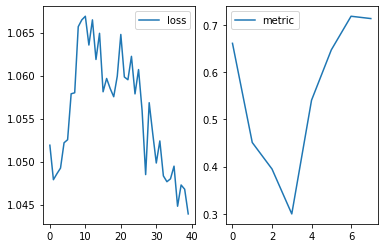

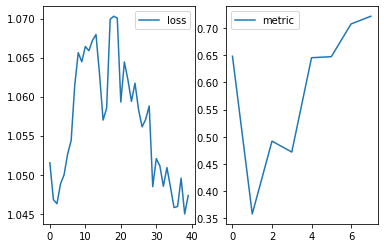

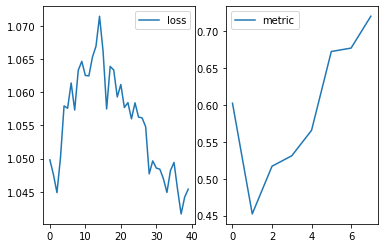

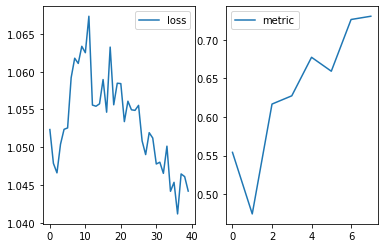

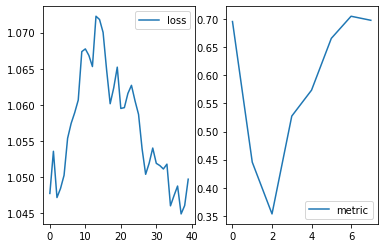

In [26]:
post_trans = Compose([EnsureType(), Activations(softmax=True), AsDiscrete(threshold=0.5)])

scaler = torch.cuda.amp.GradScaler() if amp else None
best_metric_epoch = -1
#writer = SummaryWriter()

for fold in range(start_fold, start_fold + num_folds):

    
    model = UNet(
    spatial_dims=3,
    in_channels=1,
    # With softmax 
    out_channels=4,
    channels=(16, 32, 64, 128,256),
    strides=(2, 2, 2, 2),
    dropout=0.2,
    num_res_units=2,
    norm="batch",
    

    )
    model.to(device)
    if load_weights:
            model.load_state_dict(torch.load(MODEL_FOLDER / f"{fold}_dict_{training_phase-1}.pth"))
    
    optimizer = torch.optim.Adam(model.parameters(), max_learning_rate,weight_decay = 1e-6)
    
    
    
    epoch_loss_values = list()
    metric_values = list()

    best_metric = -1
    print("-" * 10)
    print(f"fold {fold + 1}/{num_folds}")
    train_loader, val_loader = get_data_loader(df2d, fold,tr_transforms, batch_size)
    
    lr_scheduler = LR(optimizer, max_lr=max_learning_rate, steps_per_epoch=len(train_loader), epochs=num_epochs)
    #lr_scheduler = LR(optimizer, T_max=10, eta_min=min_learning_rate)
    for epoch in range(num_epochs):
        print("-" * 10)
        lr_val = optimizer.param_groups[0]["lr"]
        print(f"epoch {epoch + 1}/{num_epochs}  LR={lr_val}")
        model.train()
        epoch_loss = 0
        pbar = tqdm(total=len(train_loader))
        for i, batch_data in enumerate(train_loader):
            inputs, labels = batch_data["img"].to(device), batch_data["mask"].to(device)
            # dim[0] == batch
            # dim[1] == channel 1
            # dim[2] == spatial dim 1
            # dim[3] == spatial dim 2
            #Apply softmax to labels because they overlap in some cases
            labels = torch.nn.Softmax(dim=1)(labels)
            
            optimizer.zero_grad()
            if amp and scaler is not None:
                with torch.cuda.amp.autocast():
                    outputs = model(inputs)
                    loss = loss_function(outputs, labels)
                scaler.scale(loss).backward()
                torch.nn.utils.clip_grad_norm_(model.parameters(), 12) # clip gradients with amp
                scaler.step(optimizer)
                scaler.update()
            else:
                outputs = model(inputs)
                loss = loss_function(outputs, labels)
                loss.backward()
                optimizer.step()
            
            lr_scheduler.step()
            
            loss_item = loss.item()
            epoch_loss += loss_item
            epoch_len = len(train_loader) // train_loader.batch_size
            pbar.update(1)
        pbar.close()
        #plot_output_data3d(inputs[0], labels[0], post_trans(outputs[0]))
        epoch_loss /= i
        epoch_loss_values.append(epoch_loss)
        #torch.save(optimizer.state_dict(), MODEL_FOLDER / f"{fold}_optimizer_{training_phase}.pth")
        #print(labels.shape, outputs.shape)
        
        print(f"epoch {epoch + 1} average loss: {epoch_loss:.4f}")

        if (epoch + 1) % val_interval == 0:
            model.eval()
            with torch.no_grad():
                val_images = None
                val_labels = None
                val_outputs = None
                pbar = tqdm(total=len(val_loader))
                print("-" * 10)
                print(f"Validation")
                metric_function.reset()
                for i, val_data in enumerate(val_loader):
                    #if i > 0:
                    #    break
                    val_images, val_labels = val_data["img"].to(device), val_data["mask"].to(device)
                    
                    sw_batch_size = 4
                    if amp:
                        with torch.cuda.amp.autocast():
                            val_outputs = sliding_window_inference(val_images, roi_size, sw_batch_size, model)
                    else:
                        
                        val_outputs = sliding_window_inference(val_images, roi_size, sw_batch_size, model)
                    
                    val_outputs = [post_trans(i) for i in decollate_batch(val_outputs)]
                    # compute metric for current iteration
                    metric_function(y_pred=val_outputs, y=val_labels)
                    pbar.update(1)
                pbar.close()
                
                # aggregate the final mean dice result
                metric = metric_function.aggregate().item()
                print("Metric: "+str(metric))
                # reset the status for next validation round
                metric_function.reset()

                metric_values.append(metric)
                if metric > best_metric:
                    best_metric = metric
                    best_metric_epoch = epoch + 1
                    #plot_output_data3d(val_images[0], val_labels[0], val_outputs[0])
                    torch.save(model.state_dict(), MODEL_FOLDER / f"{fold}_best_dict_{training_phase}.pth")
                    print("saved new best metric model")
                print(
                    "current epoch: {} current mean dice: {:.4f} best mean dice: {:.4f} at epoch {}".format(
                        epoch + 1, metric, best_metric, best_metric_epoch
                    )
                )
                #writer.add_scalar("val_mean_dice", metric, epoch + 1)
    plot_metrics(epoch_loss_values, metric_values)
    torch.save(model.state_dict(), MODEL_FOLDER / f"{fold}_dict_{training_phase}.pth")

### Training phase 9 - use augmentation transforms - reduce LR

In [27]:
#Training settings


#fn="/media/SSD/gi-tract/uw-madison-gi-tract-image-segmentation/kaggle models/best_weights_fold_0.pth"
#model.load_state_dict(torch.load(fn),strict=False)

amp = True

training_phase = 9
load_weights = True

#tr_transforms = train_transforms[0]
#batch_size = 8

tr_transforms = train_transforms[1]
batch_size = 6

num_epochs = 20
num_folds = 5
start_fold = 0
val_interval = 5
roi_size = (256, 256, 80)

metric_function = DiceMetric(include_background=True, reduction="mean", get_not_nans=False)
loss_function = DiceCELoss(include_background=False, softmax=True)

LR = torch.optim.lr_scheduler.OneCycleLR
max_learning_rate = 0.0001
min_learning_rate = 0.001


----------
fold 1/5
Train Length: 220 Val Length: 54
----------
epoch 1/20  LR=4.000000000000002e-06


  0%|          | 0/37 [00:00<?, ?it/s]

epoch 1 average loss: 1.0470
----------
epoch 2/20  LR=1.0487758639348156e-05


  0%|          | 0/37 [00:00<?, ?it/s]

epoch 2 average loss: 1.0438
----------
epoch 3/20  LR=2.8197242383957768e-05


  0%|          | 0/37 [00:00<?, ?it/s]

epoch 3 average loss: 1.0447
----------
epoch 4/20  LR=5.2341165560391886e-05


  0%|          | 0/37 [00:00<?, ?it/s]

epoch 4 average loss: 1.0473
----------
epoch 5/20  LR=7.63928637446643e-05


  0%|          | 0/37 [00:00<?, ?it/s]

epoch 5 average loss: 1.0458


  0%|          | 0/54 [00:00<?, ?it/s]

----------
Validation
Metric: 0.7072191834449768
saved new best metric model
current epoch: 5 current mean dice: 0.7072 best mean dice: 0.7072 at epoch 5
----------
epoch 6/20  LR=9.385060307485807e-05


  0%|          | 0/37 [00:00<?, ?it/s]

epoch 6 average loss: 1.0481
----------
epoch 7/20  LR=9.99990804461518e-05


  0%|          | 0/37 [00:00<?, ?it/s]

epoch 7 average loss: 1.0462
----------
epoch 8/20  LR=9.867802699646041e-05


  0%|          | 0/37 [00:00<?, ?it/s]

epoch 8 average loss: 1.0469
----------
epoch 9/20  LR=9.49160640402625e-05


  0%|          | 0/37 [00:00<?, ?it/s]

epoch 9 average loss: 1.0449
----------
epoch 10/20  LR=8.890183210877112e-05


  0%|          | 0/37 [00:00<?, ?it/s]

epoch 10 average loss: 1.0456


  0%|          | 0/54 [00:00<?, ?it/s]

----------
Validation
Metric: 0.7129323482513428
saved new best metric model
current epoch: 10 current mean dice: 0.7129 best mean dice: 0.7129 at epoch 10
----------
epoch 11/20  LR=8.093690990427675e-05


  0%|          | 0/37 [00:00<?, ?it/s]

epoch 11 average loss: 1.0451
----------
epoch 12/20  LR=7.142069188473141e-05


  0%|          | 0/37 [00:00<?, ?it/s]

epoch 12 average loss: 1.0469
----------
epoch 13/20  LR=6.083036095790106e-05


  0%|          | 0/37 [00:00<?, ?it/s]

epoch 13 average loss: 1.0447
----------
epoch 14/20  LR=4.969696053782773e-05


  0%|          | 0/37 [00:00<?, ?it/s]

epoch 14 average loss: 1.0436
----------
epoch 15/20  LR=3.857876581060544e-05


  0%|          | 0/37 [00:00<?, ?it/s]

epoch 15 average loss: 1.0476


  0%|          | 0/54 [00:00<?, ?it/s]

----------
Validation
Metric: 0.7281319499015808
saved new best metric model
current epoch: 15 current mean dice: 0.7281 best mean dice: 0.7281 at epoch 15
----------
epoch 16/20  LR=2.8033289485395193e-05


  0%|          | 0/37 [00:00<?, ?it/s]

epoch 16 average loss: 1.0469
----------
epoch 17/20  LR=1.858932577921734e-05


  0%|          | 0/37 [00:00<?, ?it/s]

epoch 17 average loss: 1.0494
----------
epoch 18/20  LR=1.072043446685781e-05


  0%|          | 0/37 [00:00<?, ?it/s]

epoch 18 average loss: 1.0449
----------
epoch 19/20  LR=4.821194616346907e-06


  0%|          | 0/37 [00:00<?, ?it/s]

epoch 19 average loss: 1.0434
----------
epoch 20/20  LR=1.1874187468696274e-06


  0%|          | 0/37 [00:00<?, ?it/s]

epoch 20 average loss: 1.0429


  0%|          | 0/54 [00:00<?, ?it/s]

----------
Validation
Metric: 0.7275170683860779
current epoch: 20 current mean dice: 0.7275 best mean dice: 0.7281 at epoch 15
----------
fold 2/5
Train Length: 219 Val Length: 55
----------
epoch 1/20  LR=4.000000000000002e-06


  0%|          | 0/37 [00:00<?, ?it/s]

epoch 1 average loss: 1.0461
----------
epoch 2/20  LR=1.0487758639348156e-05


  0%|          | 0/37 [00:00<?, ?it/s]

epoch 2 average loss: 1.0458
----------
epoch 3/20  LR=2.8197242383957768e-05


  0%|          | 0/37 [00:00<?, ?it/s]

epoch 3 average loss: 1.0470
----------
epoch 4/20  LR=5.2341165560391886e-05


  0%|          | 0/37 [00:00<?, ?it/s]

epoch 4 average loss: 1.0466
----------
epoch 5/20  LR=7.63928637446643e-05


  0%|          | 0/37 [00:00<?, ?it/s]

epoch 5 average loss: 1.0468


  0%|          | 0/55 [00:00<?, ?it/s]

----------
Validation
Metric: 0.728847861289978
saved new best metric model
current epoch: 5 current mean dice: 0.7288 best mean dice: 0.7288 at epoch 5
----------
epoch 6/20  LR=9.385060307485807e-05


  0%|          | 0/37 [00:00<?, ?it/s]

epoch 6 average loss: 1.0458
----------
epoch 7/20  LR=9.99990804461518e-05


  0%|          | 0/37 [00:00<?, ?it/s]

epoch 7 average loss: 1.0464
----------
epoch 8/20  LR=9.867802699646041e-05


  0%|          | 0/37 [00:00<?, ?it/s]

epoch 8 average loss: 1.0443
----------
epoch 9/20  LR=9.49160640402625e-05


  0%|          | 0/37 [00:00<?, ?it/s]

epoch 9 average loss: 1.0436
----------
epoch 10/20  LR=8.890183210877112e-05


  0%|          | 0/37 [00:00<?, ?it/s]

epoch 10 average loss: 1.0443


  0%|          | 0/55 [00:00<?, ?it/s]

----------
Validation
Metric: 0.7208414077758789
current epoch: 10 current mean dice: 0.7208 best mean dice: 0.7288 at epoch 5
----------
epoch 11/20  LR=8.093690990427675e-05


  0%|          | 0/37 [00:00<?, ?it/s]

epoch 11 average loss: 1.0458
----------
epoch 12/20  LR=7.142069188473141e-05


  0%|          | 0/37 [00:00<?, ?it/s]

epoch 12 average loss: 1.0450
----------
epoch 13/20  LR=6.083036095790106e-05


  0%|          | 0/37 [00:00<?, ?it/s]

epoch 13 average loss: 1.0442
----------
epoch 14/20  LR=4.969696053782773e-05


  0%|          | 0/37 [00:00<?, ?it/s]

epoch 14 average loss: 1.0472
----------
epoch 15/20  LR=3.857876581060544e-05


  0%|          | 0/37 [00:00<?, ?it/s]

epoch 15 average loss: 1.0459


  0%|          | 0/55 [00:00<?, ?it/s]

----------
Validation
Metric: 0.7310838103294373
saved new best metric model
current epoch: 15 current mean dice: 0.7311 best mean dice: 0.7311 at epoch 15
----------
epoch 16/20  LR=2.8033289485395193e-05


  0%|          | 0/37 [00:00<?, ?it/s]

epoch 16 average loss: 1.0443
----------
epoch 17/20  LR=1.858932577921734e-05


  0%|          | 0/37 [00:00<?, ?it/s]

epoch 17 average loss: 1.0435
----------
epoch 18/20  LR=1.072043446685781e-05


  0%|          | 0/37 [00:00<?, ?it/s]

epoch 18 average loss: 1.0426
----------
epoch 19/20  LR=4.821194616346907e-06


  0%|          | 0/37 [00:00<?, ?it/s]

epoch 19 average loss: 1.0441
----------
epoch 20/20  LR=1.1874187468696274e-06


  0%|          | 0/37 [00:00<?, ?it/s]

epoch 20 average loss: 1.0415


  0%|          | 0/55 [00:00<?, ?it/s]

----------
Validation
Metric: 0.7370118498802185
saved new best metric model
current epoch: 20 current mean dice: 0.7370 best mean dice: 0.7370 at epoch 20
----------
fold 3/5
Train Length: 219 Val Length: 55
----------
epoch 1/20  LR=4.000000000000002e-06


  0%|          | 0/37 [00:00<?, ?it/s]

epoch 1 average loss: 1.0478
----------
epoch 2/20  LR=1.0487758639348156e-05


  0%|          | 0/37 [00:00<?, ?it/s]

epoch 2 average loss: 1.0453
----------
epoch 3/20  LR=2.8197242383957768e-05


  0%|          | 0/37 [00:00<?, ?it/s]

epoch 3 average loss: 1.0461
----------
epoch 4/20  LR=5.2341165560391886e-05


  0%|          | 0/37 [00:00<?, ?it/s]

epoch 4 average loss: 1.0454
----------
epoch 5/20  LR=7.63928637446643e-05


  0%|          | 0/37 [00:00<?, ?it/s]

epoch 5 average loss: 1.0413


  0%|          | 0/55 [00:00<?, ?it/s]

----------
Validation
Metric: 0.7304233312606812
saved new best metric model
current epoch: 5 current mean dice: 0.7304 best mean dice: 0.7304 at epoch 5
----------
epoch 6/20  LR=9.385060307485807e-05


  0%|          | 0/37 [00:00<?, ?it/s]

epoch 6 average loss: 1.0468
----------
epoch 7/20  LR=9.99990804461518e-05


  0%|          | 0/37 [00:00<?, ?it/s]

epoch 7 average loss: 1.0417
----------
epoch 8/20  LR=9.867802699646041e-05


  0%|          | 0/37 [00:00<?, ?it/s]

epoch 8 average loss: 1.0456
----------
epoch 9/20  LR=9.49160640402625e-05


  0%|          | 0/37 [00:00<?, ?it/s]

epoch 9 average loss: 1.0421
----------
epoch 10/20  LR=8.890183210877112e-05


  0%|          | 0/37 [00:00<?, ?it/s]

epoch 10 average loss: 1.0399


  0%|          | 0/55 [00:00<?, ?it/s]

----------
Validation
Metric: 0.7374797463417053
saved new best metric model
current epoch: 10 current mean dice: 0.7375 best mean dice: 0.7375 at epoch 10
----------
epoch 11/20  LR=8.093690990427675e-05


  0%|          | 0/37 [00:00<?, ?it/s]

epoch 11 average loss: 1.0497
----------
epoch 12/20  LR=7.142069188473141e-05


  0%|          | 0/37 [00:00<?, ?it/s]

epoch 12 average loss: 1.0428
----------
epoch 13/20  LR=6.083036095790106e-05


  0%|          | 0/37 [00:00<?, ?it/s]

epoch 13 average loss: 1.0442
----------
epoch 14/20  LR=4.969696053782773e-05


  0%|          | 0/37 [00:00<?, ?it/s]

epoch 14 average loss: 1.0437
----------
epoch 15/20  LR=3.857876581060544e-05


  0%|          | 0/37 [00:00<?, ?it/s]

epoch 15 average loss: 1.0404


  0%|          | 0/55 [00:00<?, ?it/s]

----------
Validation
Metric: 0.7265719175338745
current epoch: 15 current mean dice: 0.7266 best mean dice: 0.7375 at epoch 10
----------
epoch 16/20  LR=2.8033289485395193e-05


  0%|          | 0/37 [00:00<?, ?it/s]

epoch 16 average loss: 1.0451
----------
epoch 17/20  LR=1.858932577921734e-05


  0%|          | 0/37 [00:00<?, ?it/s]

epoch 17 average loss: 1.0417
----------
epoch 18/20  LR=1.072043446685781e-05


  0%|          | 0/37 [00:00<?, ?it/s]

epoch 18 average loss: 1.0418
----------
epoch 19/20  LR=4.821194616346907e-06


  0%|          | 0/37 [00:00<?, ?it/s]

epoch 19 average loss: 1.0450
----------
epoch 20/20  LR=1.1874187468696274e-06


  0%|          | 0/37 [00:00<?, ?it/s]

epoch 20 average loss: 1.0421


  0%|          | 0/55 [00:00<?, ?it/s]

----------
Validation
Metric: 0.7505373954772949
saved new best metric model
current epoch: 20 current mean dice: 0.7505 best mean dice: 0.7505 at epoch 20
----------
fold 4/5
Train Length: 219 Val Length: 55
----------
epoch 1/20  LR=4.000000000000002e-06


  0%|          | 0/37 [00:00<?, ?it/s]

epoch 1 average loss: 1.0433
----------
epoch 2/20  LR=1.0487758639348156e-05


  0%|          | 0/37 [00:00<?, ?it/s]

epoch 2 average loss: 1.0457
----------
epoch 3/20  LR=2.8197242383957768e-05


  0%|          | 0/37 [00:00<?, ?it/s]

epoch 3 average loss: 1.0440
----------
epoch 4/20  LR=5.2341165560391886e-05


  0%|          | 0/37 [00:00<?, ?it/s]

epoch 4 average loss: 1.0466
----------
epoch 5/20  LR=7.63928637446643e-05


  0%|          | 0/37 [00:00<?, ?it/s]

epoch 5 average loss: 1.0452


  0%|          | 0/55 [00:00<?, ?it/s]

----------
Validation
Metric: 0.7303147315979004
saved new best metric model
current epoch: 5 current mean dice: 0.7303 best mean dice: 0.7303 at epoch 5
----------
epoch 6/20  LR=9.385060307485807e-05


  0%|          | 0/37 [00:00<?, ?it/s]

epoch 6 average loss: 1.0499
----------
epoch 7/20  LR=9.99990804461518e-05


  0%|          | 0/37 [00:00<?, ?it/s]

epoch 7 average loss: 1.0454
----------
epoch 8/20  LR=9.867802699646041e-05


  0%|          | 0/37 [00:00<?, ?it/s]

epoch 8 average loss: 1.0460
----------
epoch 9/20  LR=9.49160640402625e-05


  0%|          | 0/37 [00:00<?, ?it/s]

epoch 9 average loss: 1.0442
----------
epoch 10/20  LR=8.890183210877112e-05


  0%|          | 0/37 [00:00<?, ?it/s]

epoch 10 average loss: 1.0441


  0%|          | 0/55 [00:00<?, ?it/s]

----------
Validation
Metric: 0.7150691747665405
current epoch: 10 current mean dice: 0.7151 best mean dice: 0.7303 at epoch 5
----------
epoch 11/20  LR=8.093690990427675e-05


  0%|          | 0/37 [00:00<?, ?it/s]

epoch 11 average loss: 1.0437
----------
epoch 12/20  LR=7.142069188473141e-05


  0%|          | 0/37 [00:00<?, ?it/s]

epoch 12 average loss: 1.0419
----------
epoch 13/20  LR=6.083036095790106e-05


  0%|          | 0/37 [00:00<?, ?it/s]

epoch 13 average loss: 1.0443
----------
epoch 14/20  LR=4.969696053782773e-05


  0%|          | 0/37 [00:00<?, ?it/s]

epoch 14 average loss: 1.0476
----------
epoch 15/20  LR=3.857876581060544e-05


  0%|          | 0/37 [00:00<?, ?it/s]

epoch 15 average loss: 1.0443


  0%|          | 0/55 [00:00<?, ?it/s]

----------
Validation
Metric: 0.7404732704162598
saved new best metric model
current epoch: 15 current mean dice: 0.7405 best mean dice: 0.7405 at epoch 15
----------
epoch 16/20  LR=2.8033289485395193e-05


  0%|          | 0/37 [00:00<?, ?it/s]

epoch 16 average loss: 1.0424
----------
epoch 17/20  LR=1.858932577921734e-05


  0%|          | 0/37 [00:00<?, ?it/s]

epoch 17 average loss: 1.0431
----------
epoch 18/20  LR=1.072043446685781e-05


  0%|          | 0/37 [00:00<?, ?it/s]

epoch 18 average loss: 1.0423
----------
epoch 19/20  LR=4.821194616346907e-06


  0%|          | 0/37 [00:00<?, ?it/s]

epoch 19 average loss: 1.0427
----------
epoch 20/20  LR=1.1874187468696274e-06


  0%|          | 0/37 [00:00<?, ?it/s]

epoch 20 average loss: 1.0456


  0%|          | 0/55 [00:00<?, ?it/s]

----------
Validation
Metric: 0.7408037781715393
saved new best metric model
current epoch: 20 current mean dice: 0.7408 best mean dice: 0.7408 at epoch 20
----------
fold 5/5
Train Length: 219 Val Length: 55
----------
epoch 1/20  LR=4.000000000000002e-06


  0%|          | 0/37 [00:00<?, ?it/s]

epoch 1 average loss: 1.0442
----------
epoch 2/20  LR=1.0487758639348156e-05


  0%|          | 0/37 [00:00<?, ?it/s]

epoch 2 average loss: 1.0443
----------
epoch 3/20  LR=2.8197242383957768e-05


  0%|          | 0/37 [00:00<?, ?it/s]

epoch 3 average loss: 1.0461
----------
epoch 4/20  LR=5.2341165560391886e-05


  0%|          | 0/37 [00:00<?, ?it/s]

epoch 4 average loss: 1.0459
----------
epoch 5/20  LR=7.63928637446643e-05


  0%|          | 0/37 [00:00<?, ?it/s]

epoch 5 average loss: 1.0469


  0%|          | 0/55 [00:00<?, ?it/s]

----------
Validation
Metric: 0.697402834892273
saved new best metric model
current epoch: 5 current mean dice: 0.6974 best mean dice: 0.6974 at epoch 5
----------
epoch 6/20  LR=9.385060307485807e-05


  0%|          | 0/37 [00:00<?, ?it/s]

epoch 6 average loss: 1.0458
----------
epoch 7/20  LR=9.99990804461518e-05


  0%|          | 0/37 [00:00<?, ?it/s]

epoch 7 average loss: 1.0474
----------
epoch 8/20  LR=9.867802699646041e-05


  0%|          | 0/37 [00:00<?, ?it/s]

epoch 8 average loss: 1.0449
----------
epoch 9/20  LR=9.49160640402625e-05


  0%|          | 0/37 [00:00<?, ?it/s]

epoch 9 average loss: 1.0471
----------
epoch 10/20  LR=8.890183210877112e-05


  0%|          | 0/37 [00:00<?, ?it/s]

epoch 10 average loss: 1.0446


  0%|          | 0/55 [00:00<?, ?it/s]

----------
Validation
Metric: 0.711523175239563
saved new best metric model
current epoch: 10 current mean dice: 0.7115 best mean dice: 0.7115 at epoch 10
----------
epoch 11/20  LR=8.093690990427675e-05


  0%|          | 0/37 [00:00<?, ?it/s]

epoch 11 average loss: 1.0452
----------
epoch 12/20  LR=7.142069188473141e-05


  0%|          | 0/37 [00:00<?, ?it/s]

epoch 12 average loss: 1.0468
----------
epoch 13/20  LR=6.083036095790106e-05


  0%|          | 0/37 [00:00<?, ?it/s]

epoch 13 average loss: 1.0466
----------
epoch 14/20  LR=4.969696053782773e-05


  0%|          | 0/37 [00:00<?, ?it/s]

epoch 14 average loss: 1.0439
----------
epoch 15/20  LR=3.857876581060544e-05


  0%|          | 0/37 [00:00<?, ?it/s]

epoch 15 average loss: 1.0480


  0%|          | 0/55 [00:00<?, ?it/s]

----------
Validation
Metric: 0.7145296931266785
saved new best metric model
current epoch: 15 current mean dice: 0.7145 best mean dice: 0.7145 at epoch 15
----------
epoch 16/20  LR=2.8033289485395193e-05


  0%|          | 0/37 [00:00<?, ?it/s]

epoch 16 average loss: 1.0447
----------
epoch 17/20  LR=1.858932577921734e-05


  0%|          | 0/37 [00:00<?, ?it/s]

epoch 17 average loss: 1.0435
----------
epoch 18/20  LR=1.072043446685781e-05


  0%|          | 0/37 [00:00<?, ?it/s]

epoch 18 average loss: 1.0475
----------
epoch 19/20  LR=4.821194616346907e-06


  0%|          | 0/37 [00:00<?, ?it/s]

epoch 19 average loss: 1.0421
----------
epoch 20/20  LR=1.1874187468696274e-06


  0%|          | 0/37 [00:00<?, ?it/s]

epoch 20 average loss: 1.0495


  0%|          | 0/55 [00:00<?, ?it/s]

----------
Validation
Metric: 0.7174703478813171
saved new best metric model
current epoch: 20 current mean dice: 0.7175 best mean dice: 0.7175 at epoch 20


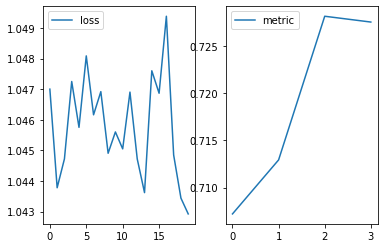

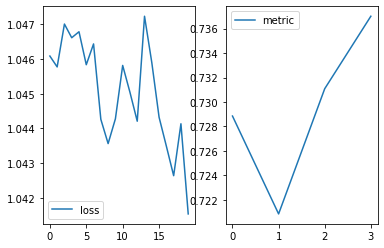

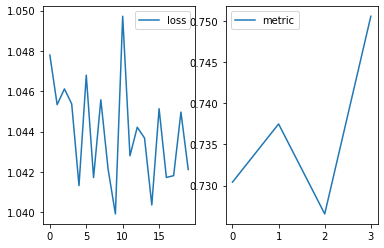

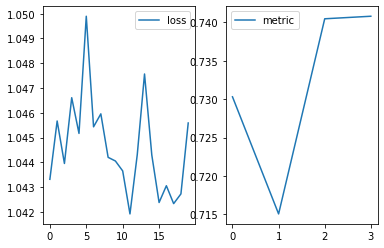

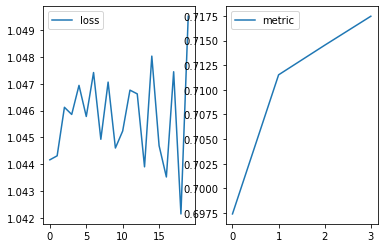

In [28]:
post_trans = Compose([EnsureType(), Activations(softmax=True), AsDiscrete(threshold=0.5)])

scaler = torch.cuda.amp.GradScaler() if amp else None
best_metric_epoch = -1
#writer = SummaryWriter()

for fold in range(start_fold, start_fold + num_folds):

    
    model = UNet(
    spatial_dims=3,
    in_channels=1,
    # With softmax 
    out_channels=4,
    channels=(16, 32, 64, 128,256),
    strides=(2, 2, 2, 2),
    dropout=0.2,
    num_res_units=2,
    norm="batch",
    

    )
    model.to(device)
    if load_weights:
            model.load_state_dict(torch.load(MODEL_FOLDER / f"{fold}_dict_{training_phase-1}.pth"))
    
    optimizer = torch.optim.Adam(model.parameters(), max_learning_rate,weight_decay = 1e-6)
    
    
    
    epoch_loss_values = list()
    metric_values = list()

    best_metric = -1
    print("-" * 10)
    print(f"fold {fold + 1}/{num_folds}")
    train_loader, val_loader = get_data_loader(df2d, fold,tr_transforms, batch_size)
    
    lr_scheduler = LR(optimizer, max_lr=max_learning_rate, steps_per_epoch=len(train_loader), epochs=num_epochs)
    #lr_scheduler = LR(optimizer, T_max=10, eta_min=min_learning_rate)
    for epoch in range(num_epochs):
        print("-" * 10)
        lr_val = optimizer.param_groups[0]["lr"]
        print(f"epoch {epoch + 1}/{num_epochs}  LR={lr_val}")
        model.train()
        epoch_loss = 0
        pbar = tqdm(total=len(train_loader))
        for i, batch_data in enumerate(train_loader):
            inputs, labels = batch_data["img"].to(device), batch_data["mask"].to(device)
            # dim[0] == batch
            # dim[1] == channel 1
            # dim[2] == spatial dim 1
            # dim[3] == spatial dim 2
            #Apply softmax to labels because they overlap in some cases
            labels = torch.nn.Softmax(dim=1)(labels)
            
            optimizer.zero_grad()
            if amp and scaler is not None:
                with torch.cuda.amp.autocast():
                    outputs = model(inputs)
                    loss = loss_function(outputs, labels)
                scaler.scale(loss).backward()
                torch.nn.utils.clip_grad_norm_(model.parameters(), 12) # clip gradients with amp
                scaler.step(optimizer)
                scaler.update()
            else:
                outputs = model(inputs)
                loss = loss_function(outputs, labels)
                loss.backward()
                optimizer.step()
            
            lr_scheduler.step()
            
            loss_item = loss.item()
            epoch_loss += loss_item
            epoch_len = len(train_loader) // train_loader.batch_size
            pbar.update(1)
        pbar.close()
        #plot_output_data3d(inputs[0], labels[0], post_trans(outputs[0]))
        epoch_loss /= i
        epoch_loss_values.append(epoch_loss)
        #torch.save(optimizer.state_dict(), MODEL_FOLDER / f"{fold}_optimizer_{training_phase}.pth")
        #print(labels.shape, outputs.shape)
        
        print(f"epoch {epoch + 1} average loss: {epoch_loss:.4f}")

        if (epoch + 1) % val_interval == 0:
            model.eval()
            with torch.no_grad():
                val_images = None
                val_labels = None
                val_outputs = None
                pbar = tqdm(total=len(val_loader))
                print("-" * 10)
                print(f"Validation")
                metric_function.reset()
                for i, val_data in enumerate(val_loader):
                    #if i > 0:
                    #    break
                    val_images, val_labels = val_data["img"].to(device), val_data["mask"].to(device)
                    
                    sw_batch_size = 4
                    if amp:
                        with torch.cuda.amp.autocast():
                            val_outputs = sliding_window_inference(val_images, roi_size, sw_batch_size, model)
                    else:
                        
                        val_outputs = sliding_window_inference(val_images, roi_size, sw_batch_size, model)
                    
                    val_outputs = [post_trans(i) for i in decollate_batch(val_outputs)]
                    # compute metric for current iteration
                    metric_function(y_pred=val_outputs, y=val_labels)
                    pbar.update(1)
                pbar.close()
                
                # aggregate the final mean dice result
                metric = metric_function.aggregate().item()
                print("Metric: "+str(metric))
                # reset the status for next validation round
                metric_function.reset()

                metric_values.append(metric)
                if metric > best_metric:
                    best_metric = metric
                    best_metric_epoch = epoch + 1
                    #plot_output_data3d(val_images[0], val_labels[0], val_outputs[0])
                    torch.save(model.state_dict(), MODEL_FOLDER / f"{fold}_best_dict_{training_phase}.pth")
                    print("saved new best metric model")
                print(
                    "current epoch: {} current mean dice: {:.4f} best mean dice: {:.4f} at epoch {}".format(
                        epoch + 1, metric, best_metric, best_metric_epoch
                    )
                )
                #writer.add_scalar("val_mean_dice", metric, epoch + 1)
    plot_metrics(epoch_loss_values, metric_values)
    torch.save(model.state_dict(), MODEL_FOLDER / f"{fold}_dict_{training_phase}.pth")

### Training phase 10 - use augmentation transforms - reduce LR

In [29]:
#Training settings


#fn="/media/SSD/gi-tract/uw-madison-gi-tract-image-segmentation/kaggle models/best_weights_fold_0.pth"
#model.load_state_dict(torch.load(fn),strict=False)

amp = True

training_phase = 10
load_weights = True

#tr_transforms = train_transforms[0]
#batch_size = 8

tr_transforms = train_transforms[1]
batch_size = 6

num_epochs = 20
num_folds = 5
start_fold = 0
val_interval = 5
roi_size = (256, 256, 80)

metric_function = DiceMetric(include_background=True, reduction="mean", get_not_nans=False)
loss_function = DiceCELoss(include_background=False, softmax=True)

LR = torch.optim.lr_scheduler.OneCycleLR
max_learning_rate = 0.0001
min_learning_rate = 0.001


----------
fold 1/5
Train Length: 220 Val Length: 54
----------
epoch 1/20  LR=0.0001


  0%|          | 0/37 [00:00<?, ?it/s]

epoch 1 average loss: 1.0465
----------
epoch 2/20  LR=0.0001


  0%|          | 0/37 [00:00<?, ?it/s]

epoch 2 average loss: 1.0453
----------
epoch 3/20  LR=0.0001


  0%|          | 0/37 [00:00<?, ?it/s]

epoch 3 average loss: 1.0475
----------
epoch 4/20  LR=0.0001


  0%|          | 0/37 [00:00<?, ?it/s]

epoch 4 average loss: 1.0480
----------
epoch 5/20  LR=0.0001


  0%|          | 0/37 [00:00<?, ?it/s]

epoch 5 average loss: 1.0438


  0%|          | 0/54 [00:00<?, ?it/s]

----------
Validation
Metric: 0.7237750887870789
saved new best metric model
current epoch: 5 current mean dice: 0.7238 best mean dice: 0.7238 at epoch 5
----------
epoch 6/20  LR=0.0001


  0%|          | 0/37 [00:00<?, ?it/s]

epoch 6 average loss: 1.0474
----------
epoch 7/20  LR=0.0001


  0%|          | 0/37 [00:00<?, ?it/s]

epoch 7 average loss: 1.0453
----------
epoch 8/20  LR=0.0001


  0%|          | 0/37 [00:00<?, ?it/s]

epoch 8 average loss: 1.0442
----------
epoch 9/20  LR=0.0001


  0%|          | 0/37 [00:00<?, ?it/s]

epoch 9 average loss: 1.0459
----------
epoch 10/20  LR=0.0001


  0%|          | 0/37 [00:00<?, ?it/s]

epoch 10 average loss: 1.0431


  0%|          | 0/54 [00:00<?, ?it/s]

----------
Validation
Metric: 0.7247639298439026
saved new best metric model
current epoch: 10 current mean dice: 0.7248 best mean dice: 0.7248 at epoch 10
----------
epoch 11/20  LR=0.0001


  0%|          | 0/37 [00:00<?, ?it/s]

epoch 11 average loss: 1.0460
----------
epoch 12/20  LR=0.0001


  0%|          | 0/37 [00:00<?, ?it/s]

epoch 12 average loss: 1.0430
----------
epoch 13/20  LR=0.0001


  0%|          | 0/37 [00:00<?, ?it/s]

epoch 13 average loss: 1.0463
----------
epoch 14/20  LR=0.0001


  0%|          | 0/37 [00:00<?, ?it/s]

epoch 14 average loss: 1.0459
----------
epoch 15/20  LR=0.0001


  0%|          | 0/37 [00:00<?, ?it/s]

epoch 15 average loss: 1.0454


  0%|          | 0/54 [00:00<?, ?it/s]

----------
Validation
Metric: 0.7071744203567505
current epoch: 15 current mean dice: 0.7072 best mean dice: 0.7248 at epoch 10
----------
epoch 16/20  LR=0.0001


  0%|          | 0/37 [00:00<?, ?it/s]

epoch 16 average loss: 1.0469
----------
epoch 17/20  LR=0.0001


  0%|          | 0/37 [00:00<?, ?it/s]

epoch 17 average loss: 1.0439
----------
epoch 18/20  LR=0.0001


  0%|          | 0/37 [00:00<?, ?it/s]

epoch 18 average loss: 1.0442
----------
epoch 19/20  LR=0.0001


  0%|          | 0/37 [00:00<?, ?it/s]

epoch 19 average loss: 1.0466
----------
epoch 20/20  LR=0.0001


  0%|          | 0/37 [00:00<?, ?it/s]

epoch 20 average loss: 1.0456


  0%|          | 0/54 [00:00<?, ?it/s]

----------
Validation
Metric: 0.7105494737625122
current epoch: 20 current mean dice: 0.7105 best mean dice: 0.7248 at epoch 10
----------
fold 2/5
Train Length: 219 Val Length: 55
----------
epoch 1/20  LR=0.0001


  0%|          | 0/37 [00:00<?, ?it/s]

epoch 1 average loss: 1.0456
----------
epoch 2/20  LR=0.0001


  0%|          | 0/37 [00:00<?, ?it/s]

epoch 2 average loss: 1.0455
----------
epoch 3/20  LR=0.0001


  0%|          | 0/37 [00:00<?, ?it/s]

epoch 3 average loss: 1.0455
----------
epoch 4/20  LR=0.0001


  0%|          | 0/37 [00:00<?, ?it/s]

epoch 4 average loss: 1.0502
----------
epoch 5/20  LR=0.0001


  0%|          | 0/37 [00:00<?, ?it/s]

epoch 5 average loss: 1.0464


  0%|          | 0/55 [00:00<?, ?it/s]

----------
Validation
Metric: 0.718289852142334
saved new best metric model
current epoch: 5 current mean dice: 0.7183 best mean dice: 0.7183 at epoch 5
----------
epoch 6/20  LR=0.0001


  0%|          | 0/37 [00:00<?, ?it/s]

epoch 6 average loss: 1.0457
----------
epoch 7/20  LR=0.0001


  0%|          | 0/37 [00:00<?, ?it/s]

epoch 7 average loss: 1.0458
----------
epoch 8/20  LR=0.0001


  0%|          | 0/37 [00:00<?, ?it/s]

epoch 8 average loss: 1.0448
----------
epoch 9/20  LR=0.0001


  0%|          | 0/37 [00:00<?, ?it/s]

epoch 9 average loss: 1.0447
----------
epoch 10/20  LR=0.0001


  0%|          | 0/37 [00:00<?, ?it/s]

epoch 10 average loss: 1.0446


  0%|          | 0/55 [00:00<?, ?it/s]

----------
Validation
Metric: 0.7231725454330444
saved new best metric model
current epoch: 10 current mean dice: 0.7232 best mean dice: 0.7232 at epoch 10
----------
epoch 11/20  LR=0.0001


  0%|          | 0/37 [00:00<?, ?it/s]

epoch 11 average loss: 1.0443
----------
epoch 12/20  LR=0.0001


  0%|          | 0/37 [00:00<?, ?it/s]

epoch 12 average loss: 1.0440
----------
epoch 13/20  LR=0.0001


  0%|          | 0/37 [00:00<?, ?it/s]

epoch 13 average loss: 1.0462
----------
epoch 14/20  LR=0.0001


  0%|          | 0/37 [00:00<?, ?it/s]

epoch 14 average loss: 1.0447
----------
epoch 15/20  LR=0.0001


  0%|          | 0/37 [00:00<?, ?it/s]

epoch 15 average loss: 1.0449


  0%|          | 0/55 [00:00<?, ?it/s]

----------
Validation
Metric: 0.7320858240127563
saved new best metric model
current epoch: 15 current mean dice: 0.7321 best mean dice: 0.7321 at epoch 15
----------
epoch 16/20  LR=0.0001


  0%|          | 0/37 [00:00<?, ?it/s]

epoch 16 average loss: 1.0458
----------
epoch 17/20  LR=0.0001


  0%|          | 0/37 [00:00<?, ?it/s]

epoch 17 average loss: 1.0454
----------
epoch 18/20  LR=0.0001


  0%|          | 0/37 [00:00<?, ?it/s]

epoch 18 average loss: 1.0440
----------
epoch 19/20  LR=0.0001


  0%|          | 0/37 [00:00<?, ?it/s]

epoch 19 average loss: 1.0437
----------
epoch 20/20  LR=0.0001


  0%|          | 0/37 [00:00<?, ?it/s]

epoch 20 average loss: 1.0484


  0%|          | 0/55 [00:00<?, ?it/s]

----------
Validation
Metric: 0.7311156392097473
current epoch: 20 current mean dice: 0.7311 best mean dice: 0.7321 at epoch 15
----------
fold 3/5
Train Length: 219 Val Length: 55
----------
epoch 1/20  LR=0.0001


  0%|          | 0/37 [00:00<?, ?it/s]

epoch 1 average loss: 1.0436
----------
epoch 2/20  LR=0.0001


  0%|          | 0/37 [00:00<?, ?it/s]

epoch 2 average loss: 1.0461
----------
epoch 3/20  LR=0.0001


  0%|          | 0/37 [00:00<?, ?it/s]

epoch 3 average loss: 1.0420
----------
epoch 4/20  LR=0.0001


  0%|          | 0/37 [00:00<?, ?it/s]

epoch 4 average loss: 1.0462
----------
epoch 5/20  LR=0.0001


  0%|          | 0/37 [00:00<?, ?it/s]

epoch 5 average loss: 1.0431


  0%|          | 0/55 [00:00<?, ?it/s]

----------
Validation
Metric: 0.731721818447113
saved new best metric model
current epoch: 5 current mean dice: 0.7317 best mean dice: 0.7317 at epoch 5
----------
epoch 6/20  LR=0.0001


  0%|          | 0/37 [00:00<?, ?it/s]

epoch 6 average loss: 1.0437
----------
epoch 7/20  LR=0.0001


  0%|          | 0/37 [00:00<?, ?it/s]

epoch 7 average loss: 1.0438
----------
epoch 8/20  LR=0.0001


  0%|          | 0/37 [00:00<?, ?it/s]

epoch 8 average loss: 1.0422
----------
epoch 9/20  LR=0.0001


  0%|          | 0/37 [00:00<?, ?it/s]

epoch 9 average loss: 1.0431
----------
epoch 10/20  LR=0.0001


  0%|          | 0/37 [00:00<?, ?it/s]

epoch 10 average loss: 1.0438


  0%|          | 0/55 [00:00<?, ?it/s]

----------
Validation
Metric: 0.7477182745933533
saved new best metric model
current epoch: 10 current mean dice: 0.7477 best mean dice: 0.7477 at epoch 10
----------
epoch 11/20  LR=0.0001


  0%|          | 0/37 [00:00<?, ?it/s]

epoch 11 average loss: 1.0425
----------
epoch 12/20  LR=0.0001


  0%|          | 0/37 [00:00<?, ?it/s]

epoch 12 average loss: 1.0458
----------
epoch 13/20  LR=0.0001


  0%|          | 0/37 [00:00<?, ?it/s]

epoch 13 average loss: 1.0418
----------
epoch 14/20  LR=0.0001


  0%|          | 0/37 [00:00<?, ?it/s]

epoch 14 average loss: 1.0447
----------
epoch 15/20  LR=0.0001


  0%|          | 0/37 [00:00<?, ?it/s]

epoch 15 average loss: 1.0406


  0%|          | 0/55 [00:00<?, ?it/s]

----------
Validation
Metric: 0.751639723777771
saved new best metric model
current epoch: 15 current mean dice: 0.7516 best mean dice: 0.7516 at epoch 15
----------
epoch 16/20  LR=0.0001


  0%|          | 0/37 [00:00<?, ?it/s]

epoch 16 average loss: 1.0449
----------
epoch 17/20  LR=0.0001


  0%|          | 0/37 [00:00<?, ?it/s]

epoch 17 average loss: 1.0458
----------
epoch 18/20  LR=0.0001


  0%|          | 0/37 [00:00<?, ?it/s]

epoch 18 average loss: 1.0449
----------
epoch 19/20  LR=0.0001


  0%|          | 0/37 [00:00<?, ?it/s]

epoch 19 average loss: 1.0487
----------
epoch 20/20  LR=0.0001


  0%|          | 0/37 [00:00<?, ?it/s]

epoch 20 average loss: 1.0449


  0%|          | 0/55 [00:00<?, ?it/s]

----------
Validation
Metric: 0.7104871869087219
current epoch: 20 current mean dice: 0.7105 best mean dice: 0.7516 at epoch 15
----------
fold 4/5
Train Length: 219 Val Length: 55
----------
epoch 1/20  LR=0.0001


  0%|          | 0/37 [00:00<?, ?it/s]

epoch 1 average loss: 1.0450
----------
epoch 2/20  LR=0.0001


  0%|          | 0/37 [00:00<?, ?it/s]

epoch 2 average loss: 1.0441
----------
epoch 3/20  LR=0.0001


  0%|          | 0/37 [00:00<?, ?it/s]

epoch 3 average loss: 1.0451
----------
epoch 4/20  LR=0.0001


  0%|          | 0/37 [00:00<?, ?it/s]

epoch 4 average loss: 1.0458
----------
epoch 5/20  LR=0.0001


  0%|          | 0/37 [00:00<?, ?it/s]

epoch 5 average loss: 1.0454


  0%|          | 0/55 [00:00<?, ?it/s]

----------
Validation
Metric: 0.7439540028572083
saved new best metric model
current epoch: 5 current mean dice: 0.7440 best mean dice: 0.7440 at epoch 5
----------
epoch 6/20  LR=0.0001


  0%|          | 0/37 [00:00<?, ?it/s]

epoch 6 average loss: 1.0415
----------
epoch 7/20  LR=0.0001


  0%|          | 0/37 [00:00<?, ?it/s]

epoch 7 average loss: 1.0467
----------
epoch 8/20  LR=0.0001


  0%|          | 0/37 [00:00<?, ?it/s]

epoch 8 average loss: 1.0468
----------
epoch 9/20  LR=0.0001


  0%|          | 0/37 [00:00<?, ?it/s]

epoch 9 average loss: 1.0481
----------
epoch 10/20  LR=0.0001


  0%|          | 0/37 [00:00<?, ?it/s]

epoch 10 average loss: 1.0450


  0%|          | 0/55 [00:00<?, ?it/s]

----------
Validation
Metric: 0.7274885177612305
current epoch: 10 current mean dice: 0.7275 best mean dice: 0.7440 at epoch 5
----------
epoch 11/20  LR=0.0001


  0%|          | 0/37 [00:00<?, ?it/s]

epoch 11 average loss: 1.0454
----------
epoch 12/20  LR=0.0001


  0%|          | 0/37 [00:00<?, ?it/s]

epoch 12 average loss: 1.0469
----------
epoch 13/20  LR=0.0001


  0%|          | 0/37 [00:00<?, ?it/s]

epoch 13 average loss: 1.0478
----------
epoch 14/20  LR=0.0001


  0%|          | 0/37 [00:00<?, ?it/s]

epoch 14 average loss: 1.0408
----------
epoch 15/20  LR=0.0001


  0%|          | 0/37 [00:00<?, ?it/s]

epoch 15 average loss: 1.0434


  0%|          | 0/55 [00:00<?, ?it/s]

----------
Validation
Metric: 0.7322171330451965
current epoch: 15 current mean dice: 0.7322 best mean dice: 0.7440 at epoch 5
----------
epoch 16/20  LR=0.0001


  0%|          | 0/37 [00:00<?, ?it/s]

epoch 16 average loss: 1.0449
----------
epoch 17/20  LR=0.0001


  0%|          | 0/37 [00:00<?, ?it/s]

epoch 17 average loss: 1.0478
----------
epoch 18/20  LR=0.0001


  0%|          | 0/37 [00:00<?, ?it/s]

epoch 18 average loss: 1.0423
----------
epoch 19/20  LR=0.0001


  0%|          | 0/37 [00:00<?, ?it/s]

epoch 19 average loss: 1.0468
----------
epoch 20/20  LR=0.0001


  0%|          | 0/37 [00:00<?, ?it/s]

epoch 20 average loss: 1.0417


  0%|          | 0/55 [00:00<?, ?it/s]

----------
Validation
Metric: 0.7029114365577698
current epoch: 20 current mean dice: 0.7029 best mean dice: 0.7440 at epoch 5
----------
fold 5/5
Train Length: 219 Val Length: 55
----------
epoch 1/20  LR=0.0001


  0%|          | 0/37 [00:00<?, ?it/s]

epoch 1 average loss: 1.0456
----------
epoch 2/20  LR=0.0001


  0%|          | 0/37 [00:00<?, ?it/s]

epoch 2 average loss: 1.0463
----------
epoch 3/20  LR=0.0001


  0%|          | 0/37 [00:00<?, ?it/s]

epoch 3 average loss: 1.0441
----------
epoch 4/20  LR=0.0001


  0%|          | 0/37 [00:00<?, ?it/s]

epoch 4 average loss: 1.0455
----------
epoch 5/20  LR=0.0001


  0%|          | 0/37 [00:00<?, ?it/s]

epoch 5 average loss: 1.0488


  0%|          | 0/55 [00:00<?, ?it/s]

----------
Validation
Metric: 0.6961287260055542
saved new best metric model
current epoch: 5 current mean dice: 0.6961 best mean dice: 0.6961 at epoch 5
----------
epoch 6/20  LR=0.0001


  0%|          | 0/37 [00:00<?, ?it/s]

epoch 6 average loss: 1.0457
----------
epoch 7/20  LR=0.0001


  0%|          | 0/37 [00:00<?, ?it/s]

epoch 7 average loss: 1.0466
----------
epoch 8/20  LR=0.0001


  0%|          | 0/37 [00:00<?, ?it/s]

epoch 8 average loss: 1.0478
----------
epoch 9/20  LR=0.0001


  0%|          | 0/37 [00:00<?, ?it/s]

epoch 9 average loss: 1.0456
----------
epoch 10/20  LR=0.0001


  0%|          | 0/37 [00:00<?, ?it/s]

epoch 10 average loss: 1.0459


  0%|          | 0/55 [00:00<?, ?it/s]

----------
Validation
Metric: 0.6868357062339783
current epoch: 10 current mean dice: 0.6868 best mean dice: 0.6961 at epoch 5
----------
epoch 11/20  LR=0.0001


  0%|          | 0/37 [00:00<?, ?it/s]

epoch 11 average loss: 1.0397
----------
epoch 12/20  LR=0.0001


  0%|          | 0/37 [00:00<?, ?it/s]

epoch 12 average loss: 1.0488
----------
epoch 13/20  LR=0.0001


  0%|          | 0/37 [00:00<?, ?it/s]

epoch 13 average loss: 1.0440
----------
epoch 14/20  LR=0.0001


  0%|          | 0/37 [00:00<?, ?it/s]

epoch 14 average loss: 1.0442
----------
epoch 15/20  LR=0.0001


  0%|          | 0/37 [00:00<?, ?it/s]

epoch 15 average loss: 1.0412


  0%|          | 0/55 [00:00<?, ?it/s]

----------
Validation
Metric: 0.7388632893562317
saved new best metric model
current epoch: 15 current mean dice: 0.7389 best mean dice: 0.7389 at epoch 15
----------
epoch 16/20  LR=0.0001


  0%|          | 0/37 [00:00<?, ?it/s]

epoch 16 average loss: 1.0437
----------
epoch 17/20  LR=0.0001


  0%|          | 0/37 [00:00<?, ?it/s]

epoch 17 average loss: 1.0438
----------
epoch 18/20  LR=0.0001


  0%|          | 0/37 [00:00<?, ?it/s]

epoch 18 average loss: 1.0457
----------
epoch 19/20  LR=0.0001


  0%|          | 0/37 [00:00<?, ?it/s]

epoch 19 average loss: 1.0447
----------
epoch 20/20  LR=0.0001


  0%|          | 0/37 [00:00<?, ?it/s]

epoch 20 average loss: 1.0465


  0%|          | 0/55 [00:00<?, ?it/s]

----------
Validation
Metric: 0.7174620032310486
current epoch: 20 current mean dice: 0.7175 best mean dice: 0.7389 at epoch 15


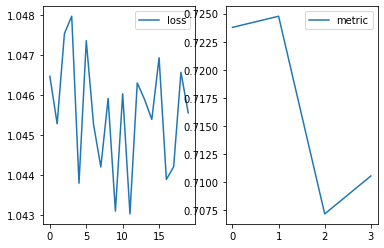

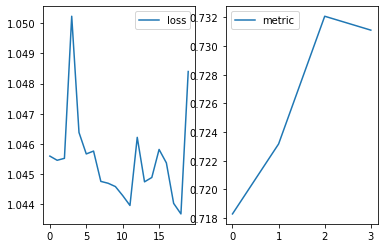

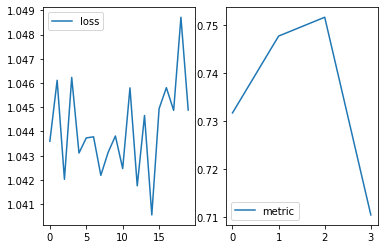

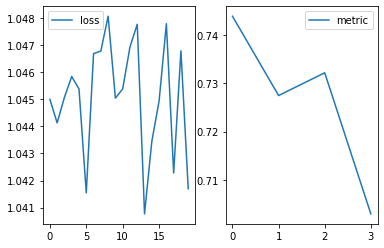

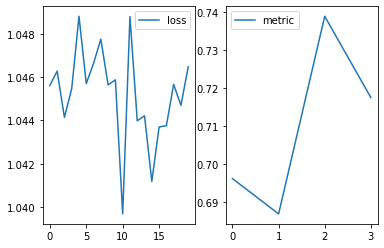

In [30]:
post_trans = Compose([EnsureType(), Activations(softmax=True), AsDiscrete(threshold=0.5)])

scaler = torch.cuda.amp.GradScaler() if amp else None
best_metric_epoch = -1
#writer = SummaryWriter()

for fold in range(start_fold, start_fold + num_folds):

    
    model = UNet(
    spatial_dims=3,
    in_channels=1,
    # With softmax 
    out_channels=4,
    channels=(16, 32, 64, 128,256),
    strides=(2, 2, 2, 2),
    dropout=0.2,
    num_res_units=2,
    norm="batch",
    

    )
    model.to(device)
    if load_weights:
            model.load_state_dict(torch.load(MODEL_FOLDER / f"{fold}_dict_{training_phase-1}.pth"))
    
    optimizer = torch.optim.Adam(model.parameters(), max_learning_rate,weight_decay = 1e-6)
    
    
    
    epoch_loss_values = list()
    metric_values = list()

    best_metric = -1
    print("-" * 10)
    print(f"fold {fold + 1}/{num_folds}")
    train_loader, val_loader = get_data_loader(df2d, fold,tr_transforms, batch_size)
    
    #lr_scheduler = LR(optimizer, max_lr=max_learning_rate, steps_per_epoch=len(train_loader), epochs=num_epochs)
    #lr_scheduler = LR(optimizer, T_max=10, eta_min=min_learning_rate)
    for epoch in range(num_epochs):
        print("-" * 10)
        lr_val = optimizer.param_groups[0]["lr"]
        print(f"epoch {epoch + 1}/{num_epochs}  LR={lr_val}")
        model.train()
        epoch_loss = 0
        pbar = tqdm(total=len(train_loader))
        for i, batch_data in enumerate(train_loader):
            inputs, labels = batch_data["img"].to(device), batch_data["mask"].to(device)
            # dim[0] == batch
            # dim[1] == channel 1
            # dim[2] == spatial dim 1
            # dim[3] == spatial dim 2
            #Apply softmax to labels because they overlap in some cases
            labels = torch.nn.Softmax(dim=1)(labels)
            
            optimizer.zero_grad()
            if amp and scaler is not None:
                with torch.cuda.amp.autocast():
                    outputs = model(inputs)
                    loss = loss_function(outputs, labels)
                scaler.scale(loss).backward()
                torch.nn.utils.clip_grad_norm_(model.parameters(), 12) # clip gradients with amp
                scaler.step(optimizer)
                scaler.update()
            else:
                outputs = model(inputs)
                loss = loss_function(outputs, labels)
                loss.backward()
                optimizer.step()
            
            #lr_scheduler.step()
            
            loss_item = loss.item()
            epoch_loss += loss_item
            epoch_len = len(train_loader) // train_loader.batch_size
            pbar.update(1)
        pbar.close()
        #plot_output_data3d(inputs[0], labels[0], post_trans(outputs[0]))
        epoch_loss /= i
        epoch_loss_values.append(epoch_loss)
        #torch.save(optimizer.state_dict(), MODEL_FOLDER / f"{fold}_optimizer_{training_phase}.pth")
        #print(labels.shape, outputs.shape)
        
        print(f"epoch {epoch + 1} average loss: {epoch_loss:.4f}")

        if (epoch + 1) % val_interval == 0:
            model.eval()
            with torch.no_grad():
                val_images = None
                val_labels = None
                val_outputs = None
                pbar = tqdm(total=len(val_loader))
                print("-" * 10)
                print(f"Validation")
                metric_function.reset()
                for i, val_data in enumerate(val_loader):
                    #if i > 0:
                    #    break
                    val_images, val_labels = val_data["img"].to(device), val_data["mask"].to(device)
                    
                    sw_batch_size = 4
                    if amp:
                        with torch.cuda.amp.autocast():
                            val_outputs = sliding_window_inference(val_images, roi_size, sw_batch_size, model)
                    else:
                        
                        val_outputs = sliding_window_inference(val_images, roi_size, sw_batch_size, model)
                    
                    val_outputs = [post_trans(i) for i in decollate_batch(val_outputs)]
                    # compute metric for current iteration
                    metric_function(y_pred=val_outputs, y=val_labels)
                    pbar.update(1)
                pbar.close()
                
                # aggregate the final mean dice result
                metric = metric_function.aggregate().item()
                print("Metric: "+str(metric))
                # reset the status for next validation round
                metric_function.reset()

                metric_values.append(metric)
                if metric > best_metric:
                    best_metric = metric
                    best_metric_epoch = epoch + 1
                    #plot_output_data3d(val_images[0], val_labels[0], val_outputs[0])
                    torch.save(model.state_dict(), MODEL_FOLDER / f"{fold}_best_dict_{training_phase}.pth")
                    print("saved new best metric model")
                print(
                    "current epoch: {} current mean dice: {:.4f} best mean dice: {:.4f} at epoch {}".format(
                        epoch + 1, metric, best_metric, best_metric_epoch
                    )
                )
                #writer.add_scalar("val_mean_dice", metric, epoch + 1)
    plot_metrics(epoch_loss_values, metric_values)
    torch.save(model.state_dict(), MODEL_FOLDER / f"{fold}_dict_{training_phase}.pth")

## Inference

In [ ]:
def validation(val_loader,metric_function,model,amp,device):
    
    
    
    post_trans = Compose([EnsureType(), Activations(softmax=True), AsDiscrete(threshold=0.2)])

    scaler = torch.cuda.amp.GradScaler() if amp else None
    



    model.eval()
    with torch.no_grad():
        val_images = None
        val_labels = None
        val_outputs = None
        pbar = tqdm(total=len(val_loader))
        metric_function.reset()
        for i, val_data in enumerate(val_loader):
            #if i > 0:
            #    break
            val_images, val_labels = val_data["img"].to(device), val_data["mask"].to(device)

            sw_batch_size = 4
            if amp:
                with torch.cuda.amp.autocast():
                    val_outputs = sliding_window_inference(val_images, roi_size, sw_batch_size, model)
            else:

                val_outputs = sliding_window_inference(val_images, roi_size, sw_batch_size, model)

            val_outputs = [post_trans(i) for i in decollate_batch(val_outputs)]
            # compute metric for current iteration
            metric_function(y_pred=val_outputs[0], y=val_labels)
            pbar.update(1)
        pbar.close()

        # aggregate the final mean dice result
        metric = metric_function.aggregate().item()
        print("Metric: "+str(metric))
        # reset the status for next validation round
        metric_function.reset()


        



In [ ]:
post_trans = Compose([EnsureType(), Activations(softmax=True), AsDiscrete(threshold=0.5)])

In [ ]:
data = iter(val_loader)

In [ ]:
check_data = next(data)

In [ ]:
val_images, val_labels = check_data["img"].to(device), check_data["mask"].to(device)

In [ ]:
with torch.cuda.amp.autocast():
    val_outputs = sliding_window_inference(val_images, roi_size, 4, model)

In [ ]:
val_outputs.shape

In [ ]:
val_outputs2 = [post_trans(i) for i in decollate_batch(val_outputs)][0]

In [ ]:
val_outputs2[0].shape

In [ ]:
val_outputs2[0,3].min()

In [ ]:
val_outputs2 = torch.softmax(val_outputs,dim=1)

In [ ]:
plot_data3d(check_data['img'], val_outputs2.detach(),0,120)

In [ ]:

plot_data3d(check_data['img'], check_data['mask'],0,80)

In [ ]:
def plot_data3d(image, mask,b,start_frame):
    
    img = rearrange(image, 'n c h w d -> n h w d c').cpu().numpy()
    mask = rearrange(mask, 'n c h w d -> n h w d c').cpu().numpy()
    # Plot first 4 images
    fig, ax = plt.subplots(4, 4, figsize=(20,20))
    
    #print(image.shape, img.shape)
    ax = ax.ravel()
    ims = []
    masks = []

    # Start by adding the image to each axis
    for i in range(len(ax)):
        im_min = img[b].min()
        im_max = img[b].max()
        # Plot the i'th image at the starting frame
        im_plot = ax[i].imshow(
            img[b,:,:,start_frame+i,:],
            cmap='bone',
            vmin=im_min,
            vmax=im_max
        )
        #print(mask.max())
        mask_plot = ax[i].imshow(mask[b,:,:,start_frame+i,0:3], alpha=0.3)
        #ims.append(im_plot)
        #masks.append(mask_plot)
        ax[i].axis('off')
    print(im_min, im_max)
    print(img.shape)